 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [2]:
reset -fs

# Loading Modules and Datasets

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import xgboost as xgb
from xgboost import XGBRegressor
import urllib.request
import json
import time
from datetime import datetime
import requests
from fbprophet import Prophet

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [4]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [5]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_localize(None).to_series(keep_tz=True)

# resampling to a time range of 15 minutes and interpolate between the hourly values
df_fin = df_fin.resample('10min', axis='index').interpolate()
df_fin = df_fin.fillna(method='ffill')

# creating columns with name of the day and month
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

In [6]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [7]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_localize(None).to_series(keep_tz=True)

# resample 
# df_norm = df_norm.resample('H').mean()

In [8]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [9]:
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [10]:
# testing if there are any missing values
print(df_norm[df_norm.isnull().any(axis=1)])
print(df_fin[df_fin.isnull().any(axis=1)])

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm]
Index: []
Empty DataFrame
Columns: [dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, t_pfg30_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pfg30_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name]
Index: []

[0 rows x 28 columns]


# Data Cleaning

In [11]:
# drop rows with NaN, since both datasets don't have the same timeframe
df = df.dropna()
df

power_mw_obsnorm  power_available_mw_obsnorm  \
2018-01-01 06:00:00          0.486251                    0.911849   
2018-01-01 06:10:00          0.528225                    0.932739   
2018-01-01 06:20:00          0.500030                    0.905168   
2018-01-01 06:30:00          0.436176                    0.918136   
2018-01-01 06:40:00          0.423738                    0.920801   
...                               ...                         ...   
2019-06-25 01:10:00          0.290788                    0.317405   
2019-06-25 01:20:00          0.297746                    0.330850   
2019-06-25 01:30:00          0.310582                    0.341660   
2019-06-25 01:40:00          0.308457                    0.338645   
2019-06-25 01:50:00          0.309148                    0.339853   

                     target_losses_norm  dswrf_sfc_wm2  gust_sfc_ms  \
2018-01-01 06:00:00            0.425598            0.0    16.777032   
2018-01-01 06:10:00            0.404513            0.0    16.748651   
2018-01-01 06:20:00            0.405137            0.0    16.720270   
2018-01-01 06:30:00            0.481961            0.0    16.691888   
2018-01-01 06:40:00            0.497063            0.0    16.663507   
...                                 ...            ...          ...   
2019-06-25 01:10:00            0.026618            0.0    10.359493   
2019-06-25 01:20:00            0.033104            0.0    10.198118   
2019-06-25 01:30:00            0.031078            0.0    10.036744   
2019-06-25 01:40:00            0.030189            0.0     9.875370   
2019-06-25 01:50:00            0.030705            0.0     9.713995   

                      hpbl_sfc_m      msl_ms_pa  pottemp_80mto0m_K    q_2m_1  \
2018-01-01 06:00:00  1349.927656   99212.062500           0.559356  0.005105   
2018-01-01 06:10:00  1350.376965   99220.020833           0.554256  0.005088   
2018-01-01 06:20:00  1350.826273   99227.979167           0.549156  0.005072   
2018-01-01 06:30:00  1351.275581   99235.937500           0.544055  0.005055   
2018-01-01 06:40:00  1351.724889   99243.895833           0.538955  0.005038   
...                          ...            ...                ...       ...   
2019-06-25 01:10:00   243.857254  102171.072917           2.345096  0.009911   
2019-06-25 01:20:00   237.270356  102161.183333           2.351379  0.009859   
2019-06-25 01:30:00   230.683457  102151.293750           2.357663  0.009808   
2019-06-25 01:40:00   224.096558  102141.404167           2.363946  0.009756   
2019-06-25 01:50:00   217.509660  102131.514583           2.370229  0.009704   

                     q_pfg30_1  ...  wdir_pl925_dn  wsp_100m_ms  wsp_10m_ms  \
2018-01-01 06:00:00   0.004852  ...      58.963042    16.548291    9.772748   
2018-01-01 06:10:00   0.004833  ...      60.237190    16.589409    9.804977   
2018-01-01 06:20:00   0.004815  ...      61.511338    16.630528    9.837206   
2018-01-01 06:30:00   0.004796  ...      62.785487    16.671646    9.869435   
2018-01-01 06:40:00   0.004777  ...      64.059635    16.712765    9.901665   
...                        ...  ...            ...          ...         ...   
2019-06-25 01:10:00   0.009590  ...     343.567564     8.744555    4.072132   
2019-06-25 01:20:00   0.009548  ...     343.433284     8.710395    4.049734   
2019-06-25 01:30:00   0.009506  ...     343.299005     8.676235    4.027335   
2019-06-25 01:40:00   0.009464  ...     343.164726     8.642075    4.004936   
2019-06-25 01:50:00   0.009422  ...     343.030446     8.607915    3.982537   

                     wsp_pfg30_ms  wsp_pl925_ms                created_on  \
2018-01-01 06:00:00     16.622077     21.963719 2018-01-01 00:00:00+00:00   
2018-01-01 06:10:00     16.657162     21.955989 2018-01-01 00:00:00+00:00   
2018-01-01 06:20:00     16.692246     21.948260 2018-01-01 00:00:00+00:00   
2018-01-01 06:30:00     16.727331     21.940530 2018-01-01 00:00:00+00:00   
2018-01-01 06:40:00     16.762416     21.932

In [12]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

0.15290214960235474
0.7652005515770703
-0.46037204631724776
91.2075218095992
-0.0699522423858068
0.75
Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


In [13]:
# encoding the day of the week as well as the month
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

In [14]:
# check duplicates
df[df.index.duplicated()]

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm, dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, January, February, March, April, May, June, July, August, September, October, November, December]
Index: []

[0 rows x 47 columns]

# Modelling

## Train test split

In [15]:
features =[#'dswrf_sfc_wm2', 
    'gust_sfc_ms',
     'hpbl_sfc_m',
    #'msl_ms_pa',
   #    'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 
    'r_pl925_perc',
    #   'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc',
    #'tccmedium_sfc_perc', 
#           'wdir_100m_dn', 'wdir_10m_dn',
 #      'wdir_pl925_dn', 
    'wsp_100m_ms'
    , 'wsp_10m_ms', 'wsp_pl925_ms'
       #'created_on',
#           'azimuth', 'elevation',
          ]    
X = df[features]
Y1 = df['power_mw_obsnorm']
Y2 = df['power_available_mw_obsnorm']
Y3 = df['target_losses_norm']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.25, random_state=5)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.25, random_state=5)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y3, test_size=0.25, random_state=5)

# Time series split
tscv = TimeSeriesSplit(max_train_size=20)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train_loss, x_test_loss = x[train_index], x[test_index]
    y_train_loss, y_test_loss = y[train_index], y[test_index]

## Train test split for timeframes

In [16]:
def timeframe_train_test(x, y, time_start, time_end):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

In [17]:
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-06-25 01:00'
x_train_tf, x_test_tf, y_train_tf, y_test_tf = timeframe_train_test(X, Y3, timeframe_start, timeframe_end)

In [18]:
def tf_rolling_train_test(x, y, time_start, time_end, interval):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

## Functions for evaluation and plotting

### Functions for evaluating forecasts

In [19]:
def regr_eval(y_test, y_pred, return_scores=False, print_scores=True):
    if print_scores==True:
        print('Mean squared error: '+str(round(mean_squared_error(y_test, y_pred),6)))
        print('Root mean squared error: '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),6)))
        print('Explained variance score: '+str(round(explained_variance_score(y_test, y_pred),6)))
        print('R-squared score: '+str(round(r2_score(y_test, y_pred),6)))
    if return_scores==True:
        return mean_squared_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred)),explained_variance_score(y_test, y_pred),r2_score(y_test, y_pred)

In [20]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [21]:
# preprocessing data
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)

### Functions for plotting

In [22]:
def plot_resid(y_test, y_pred):
    x = y_test.index
    y1 = y_test
    y2 = y_pred
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y1, name='True Values', line_color='#32a852', mode='markers'))
    fig.add_trace(go.Scatter(x=x, y=y2, name='Predicted Values', line_color='#23e2f7', mode='markers'))
    
    fig.show()

In [23]:
def plot_resid_hist(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x, name='Distribution of errors'))
      
    fig.show()

In [24]:
def plot_resid_boxp(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Box(x=x, name='Distribution of errors'))
      
    fig.show()

In [25]:
def plot_pred_timeframe(y_test, y_pred):
    for i in range(1,7):
        fig, ax = plt.subplots(figsize=(20,10))
        df_test = y_test.to_frame(name='true')
        df_test['pred'] = y_pred
        df_test = df_test[df_test.index.month == i]
        y_te = df_test['true'].resample('H').mean()
        y_pre = df_test['pred'].resample('H').mean()
        y_te.plot(label='True',color='orange')
        y_pre.plot(label='Predicted',color='blue')
        plt.legend()
    plt.figure(figsize=(20,10.0))
    plt.show()

In [26]:
def plot_errors(y_list):
    y = y_list
    x = y_list.index
    fig, ax = plt.subplots(figsize=(12, 12))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.plot(x, y, )
    
    ax.legend(y_list.columns)    
    plt.title('Errors over time')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.show()

## Model prediction with lag

In [27]:
def modelling_rolling(x, y, time_start, time_end, regressor, days=1, lag=6):
    rsquared = []
    mean_squared = []
    root_mean_squared = []
    explained_variance = []
    results = [rsquared, mean_squared, root_mean_squared, explained_variance]
    
    df_y = pd.DataFrame()
    df_y2 = pd.Series(name='pred')
    
    date_list = pd.date_range(time_end, periods=24/(lag/6)*days, freq='{}H'.format(lag/6))
    
    for i in range(1,(len(date_list)-1)):
        train_frame = (x.index >= time_start) & (x.index < date_list[i])
        test_frame = (x.index >= date_list[i-1]) & (x.index < date_list[i+1])
        x_test = x[test_frame].shift(lag)[lag:]
        y_test = y[test_frame][lag:]
        x_train = x[train_frame].shift(lag)[lag:]
        y_train = y[train_frame][lag:]
        
        model = regressor
        model = model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        mea, roo, expl, rsq = regr_eval(y_test, y_test_pred, return_scores=True, print_scores=False)
        
        df_y = df_y.append(pd.DataFrame(y_test))
        df_y2 = df_y2.append((pd.Series(y_test_pred, index=y_test.index)))
        
        rsquared.append(rsq)
        mean_squared.append(mea)
        root_mean_squared.append(roo)
        explained_variance.append(expl)

    df_y2 = pd.DataFrame(df_y2,index=df_y.index)
    df_y = df_y.join(df_y2, lsuffix="d")
    df_y = df_y.rename(columns={'target_losses_norm':'true',0:'predicted'})
    df_y['error'] = df_y['true']-df_y['predicted']
    return results, df_y

In [28]:
timeframe_start = '2018-12-01 00:00'
timeframe_end = '2019-01-11 00:00'
results_roll, y_list_roll = modelling_rolling(X, Y3, timeframe_start, timeframe_end,
                                              SVR(kernel='rbf'), 2, 12)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [29]:
for i in range(1,4):
    lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
    res = sum(results_roll[i])/len(results_roll[i])
    print('The {} is: {}'.format(lists[i],res))

The Mean squared value is: 0.008218345585741606
The Root mean squared value is: 0.07957375410464548
The Explained variance value is: -0.6685746981770841


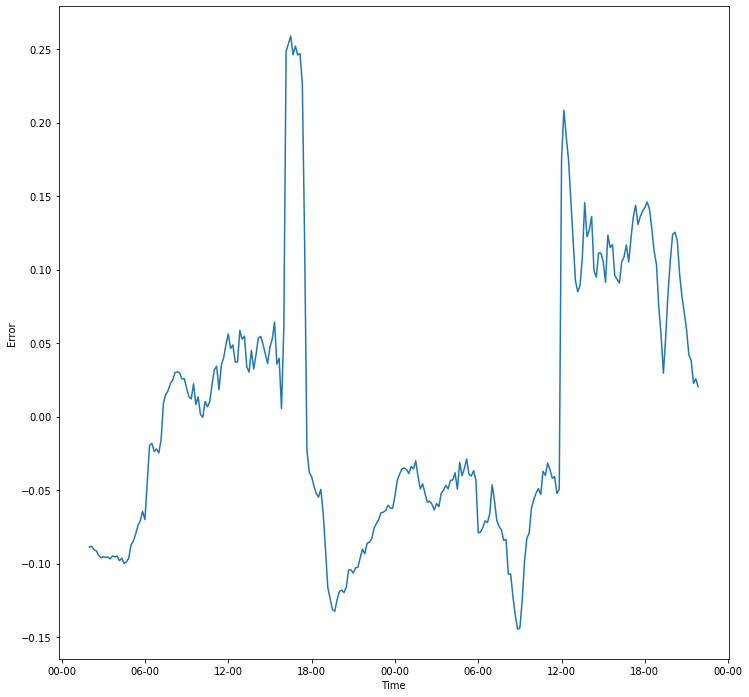

In [30]:
y = y_list_roll['error']
x = y_list_roll.index
fig, ax = plt.subplots(figsize=(12, 12))
date_form = DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(date_form)
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

## Naive time series prediction

In [31]:
def modelling_naive(x, y, time_start, time_end, hours=1, lag=6):
    # defining empty lists to store results
    rsquared = []
    mean_squared = []
    root_mean_squared = []
    explained_variance = []
    results = [rsquared, mean_squared, root_mean_squared, explained_variance]
    
    df_y = pd.DataFrame()
    df_y2 = pd.Series()
    
    date_list = pd.date_range(time_end, periods=hours, freq='H')
    for i in range(1,(len(date_list)-1)):
        train_frame = (x.index >= time_start) & (x.index < date_list[i])
        test_frame = (x.index >= date_list[i-1]) & (x.index < date_list[i+1])
        y_test = y[test_frame][lag:]
        # take the value of target_loss from 1 hour before the prediction
        y_last_train = y[train_frame][-12:-11].values
 
        y_pred = [y_last_train,y_last_train,y_last_train,y_last_train,y_last_train,y_last_train,]
        # evaluate results 
        mea, roo, expl, rsq = regr_eval(y_test, y_pred, return_scores=True, print_scores=False)
        df_y = df_y.append(pd.DataFrame(y_test))
        df_y2 = df_y2.append((pd.Series(y_pred, index=y_test.index)))
        
        rsquared.append(rsq)
        mean_squared.append(mea)
        root_mean_squared.append(roo)
        explained_variance.append(expl)
    
    # transforming results into a Dataframe
    df_y2 = pd.DataFrame(df_y2,index=df_y.index)
    df_y = df_y.join(df_y2, lsuffix="d")
    df_y = df_y.rename(columns={'target_losses_norm':'true',0:'predicted'})
    df_y['error'] = df_y['true']-df_y['predicted']
    return results, df_y

In [32]:
#predicting one timeframe
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-01-11 00:00'
results, y_list = modelling_naive(X, Y3, timeframe_start, timeframe_end, hours=48, lag=6)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [33]:
# results of one timeframe
for i in range(1,3):
    lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
    res = round((sum(results[i])/len(results[i])),10)
    print('The {} is: {}'.format(lists[i],res))

The Mean squared value is: 0.0087320008
The Root mean squared value is: 0.0597287674


In [34]:
timeframes = ['2019-01-11 00:00','2019-02-11 00:00','2019-03-20 00:00','2019-04-01 00:00','2019-06-05 00:00']

In [35]:
# predicting various timeframes - lag of 1 hour
for k,f in enumerate(timeframes):
    globals()["results_naive"+str(k)],globals()["y_list_naive"+str(k)] = modelling_naive(X, Y3, timeframe_start, f, hours=48, lag=6)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype e

In [36]:
# results of various timeframes - lag of 1 hour
for f in range(len(timeframes)):
    print(timeframes[f])
    for i in range(1,3):
        lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
        res = sum(globals()["results_naive" +str(f)][i])/len(globals()["results_naive"+str(f)][i])
        print('The {} is: {}'.format(lists[i],res))

2019-01-11 00:00
The Mean squared value is: 0.00873200079588084
The Root mean squared value is: 0.059728767394636464
2019-02-11 00:00
The Mean squared value is: 0.00893196005099639
The Root mean squared value is: 0.06516599429232967
2019-03-20 00:00
The Mean squared value is: 0.0025310320962750326
The Root mean squared value is: 0.03751745134470035
2019-04-01 00:00
The Mean squared value is: 0.0002633850577055315
The Root mean squared value is: 0.011399533261579466
2019-06-05 00:00
The Mean squared value is: 0.0018380074834674282
The Root mean squared value is: 0.028396828324704856


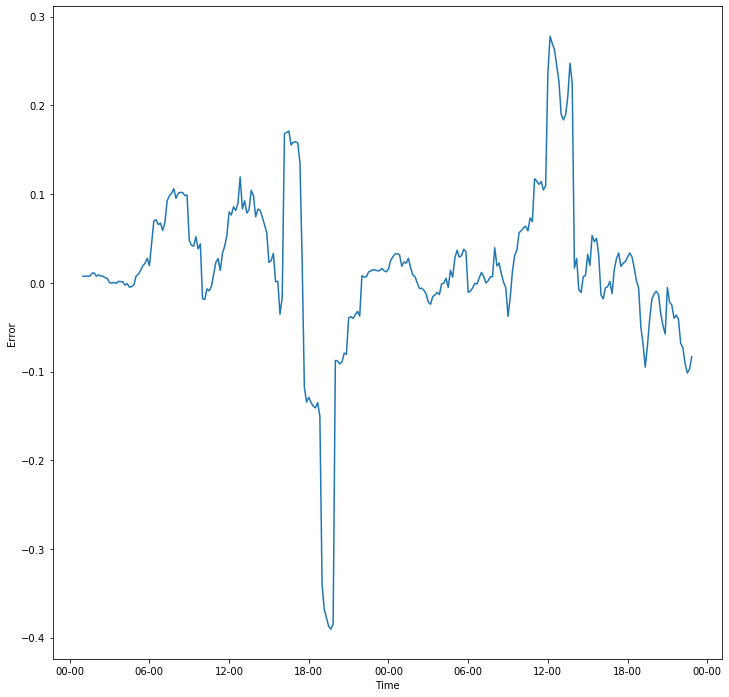

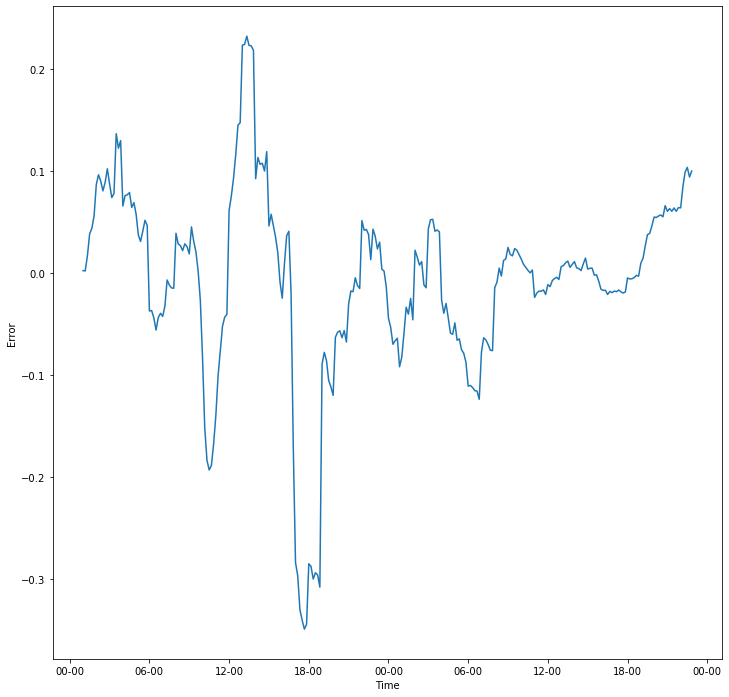

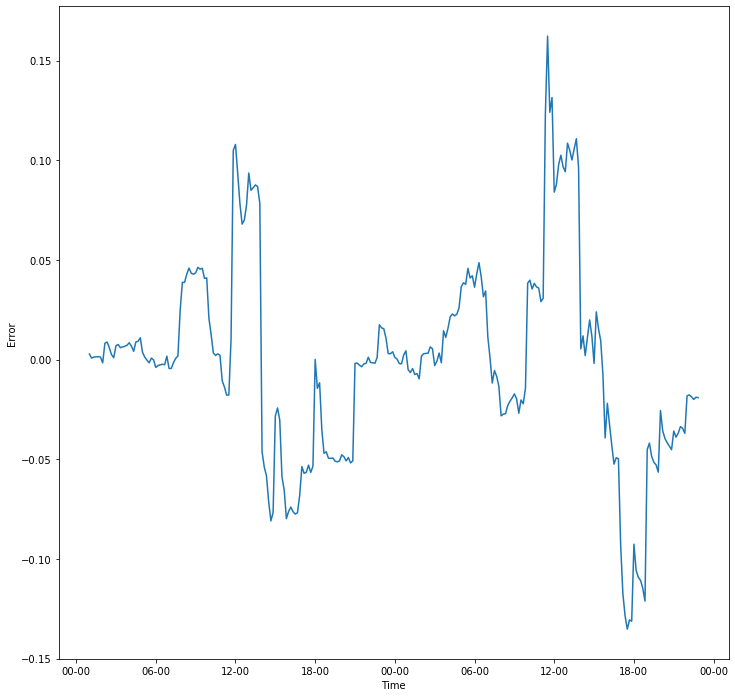

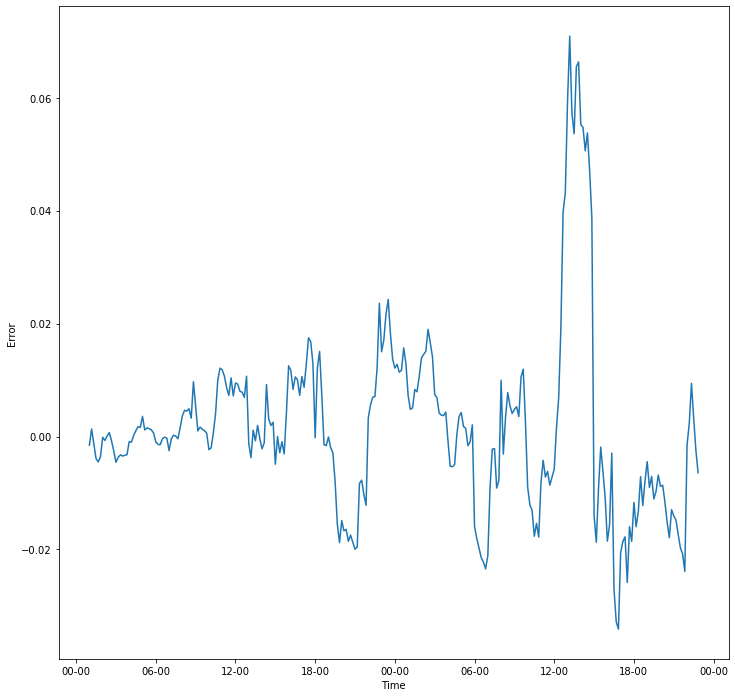

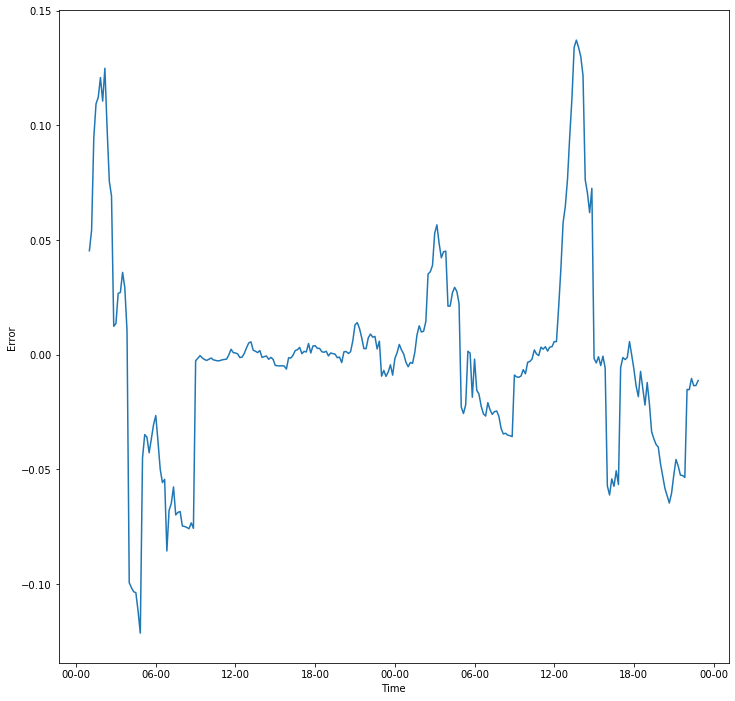

In [37]:
for i in range(len(timeframes)):
    y = globals()['y_list_naive'+str(i)]['error']
    x = globals()['y_list_naive'+str(i)].index
    fig, ax = plt.subplots(figsize=(12, 12))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.plot(x, y)
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.show()

## Comparing different regressors

In [38]:
timeframes = ['2019-01-11 00:00','2019-02-11 00:00','2019-03-20 00:00','2019-04-01 00:00','2019-06-05 00:00']

In [39]:
regression_type = [RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10, random_state=1),
                   LinearRegression(n_jobs=10),
                   SVR(kernel='rbf'),
                   GradientBoostingRegressor(),
                   XGBRegressor(objective='reg:squarederror')]

regressor_str = ['RandomForest','LinReg','SVR','GradientBoosting','XGBReg']

In [83]:
for k,f in enumerate(timeframes):
    for d,i in enumerate(regression_type):
        globals()["results_" + str(d)+str(k)],globals()["y_list_" + str(d)+str(k)] = modelling_rolling(X, Y3, timeframe_start, f,
                                              i, 2, 6)

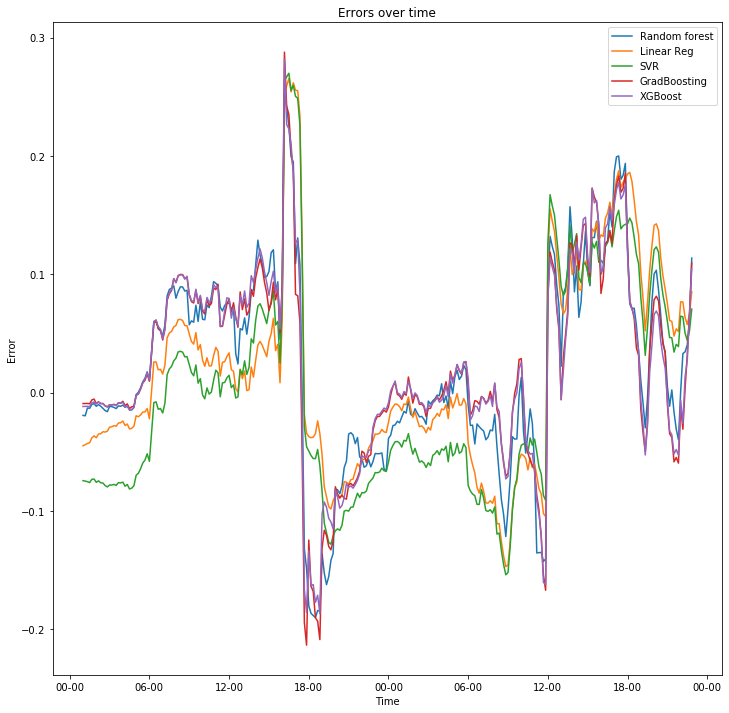

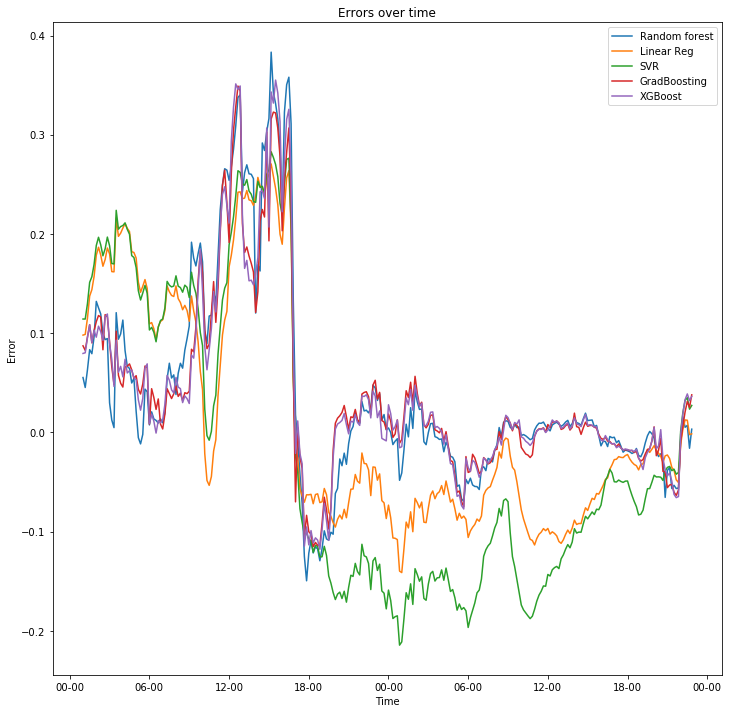

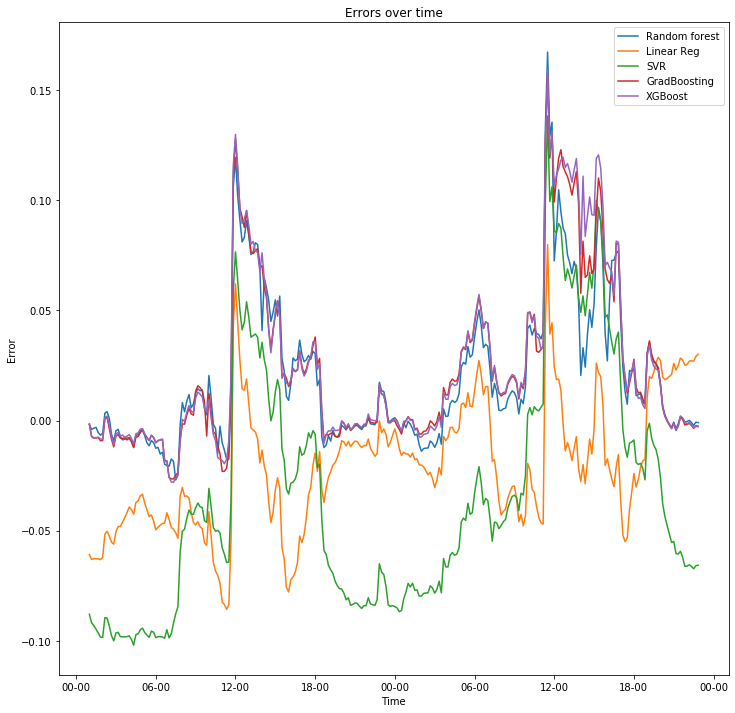

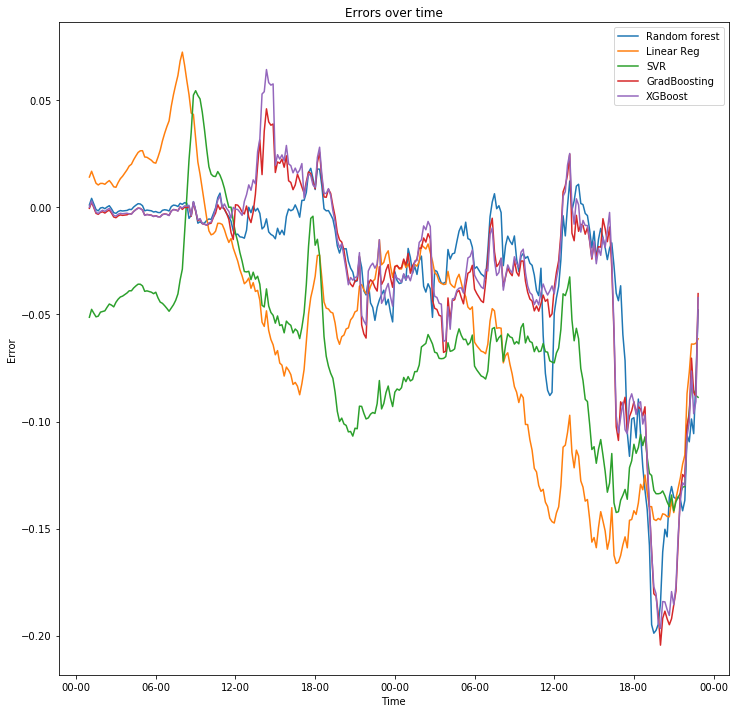

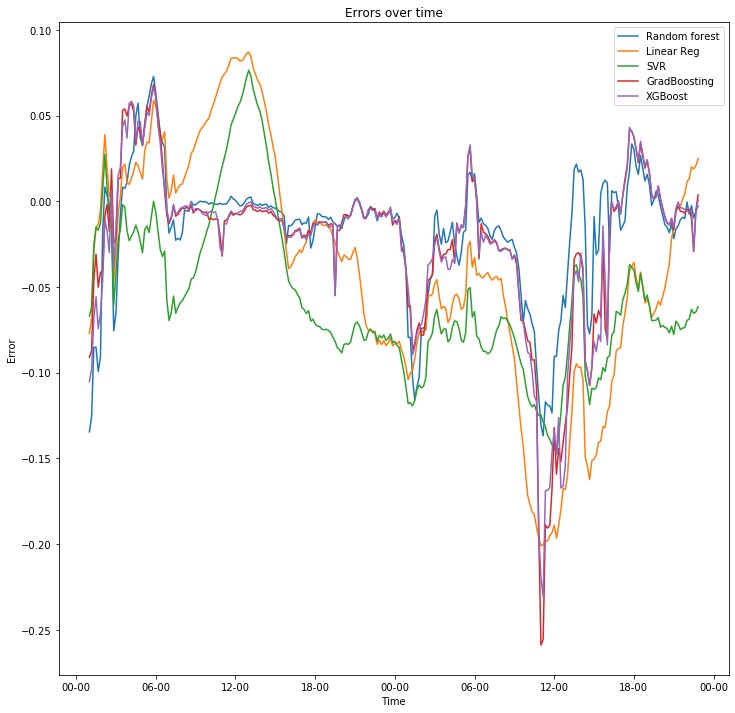

In [84]:
# combining error lists for each date - lag of 1 hour
for f in range(len(timeframes)):
    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
    for k in range(len(regressor_str)):
        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
    plot_errors(globals()["df_errors"+str(f)])

In [85]:
# results predicting different timeslots with different regressors - lag of 2 hours
for f in range(len(timeframes)):
    print(timeframes[f])
    for k in range(len(regressor_str)):
        print(regressor_str[k])
        for i in range(1,3):
            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
            print('The {} is: {}'.format(lists[i],res))

2019-01-11 00:00
RandomForest
The Mean squared value is: 0.007348090061231269
The Root mean squared value is: 0.06963570642291242
LinReg
The Mean squared value is: 0.007526191375259465
The Root mean squared value is: 0.06893854518670438
SVR
The Mean squared value is: 0.008178617658207347
The Root mean squared value is: 0.07781552468020775
GradientBoosting
The Mean squared value is: 0.007034348701110651
The Root mean squared value is: 0.06631108087359232
XGBReg
The Mean squared value is: 0.006882479378051745
The Root mean squared value is: 0.06568846375367329
2019-02-11 00:00
RandomForest
The Mean squared value is: 0.012857279891264239
The Root mean squared value is: 0.07198444910743039
LinReg
The Mean squared value is: 0.013591895649542315
The Root mean squared value is: 0.09816405633172323
SVR
The Mean squared value is: 0.02218012322140553
The Root mean squared value is: 0.1369754041920832
GradientBoosting
The Mean squared value is: 0.010001524748675057
The Root mean squared value is:

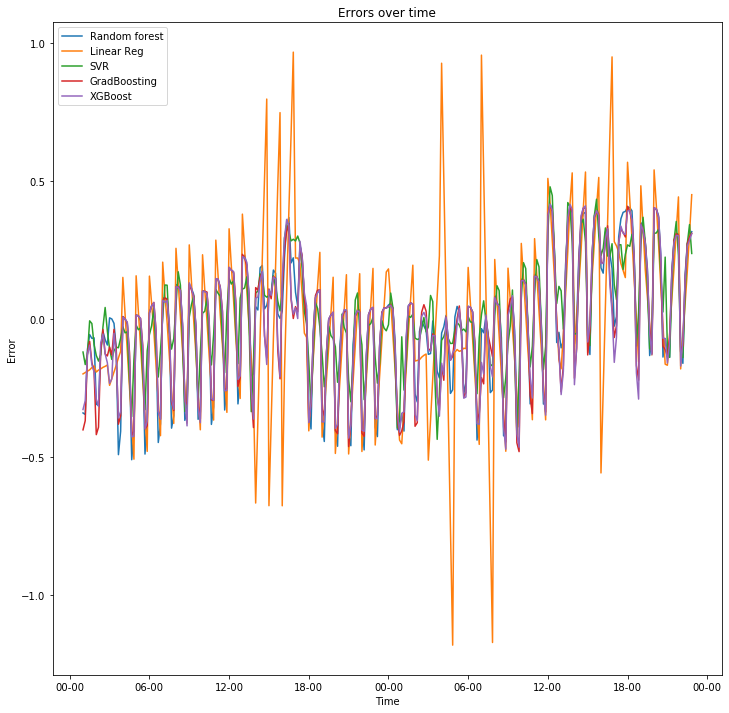

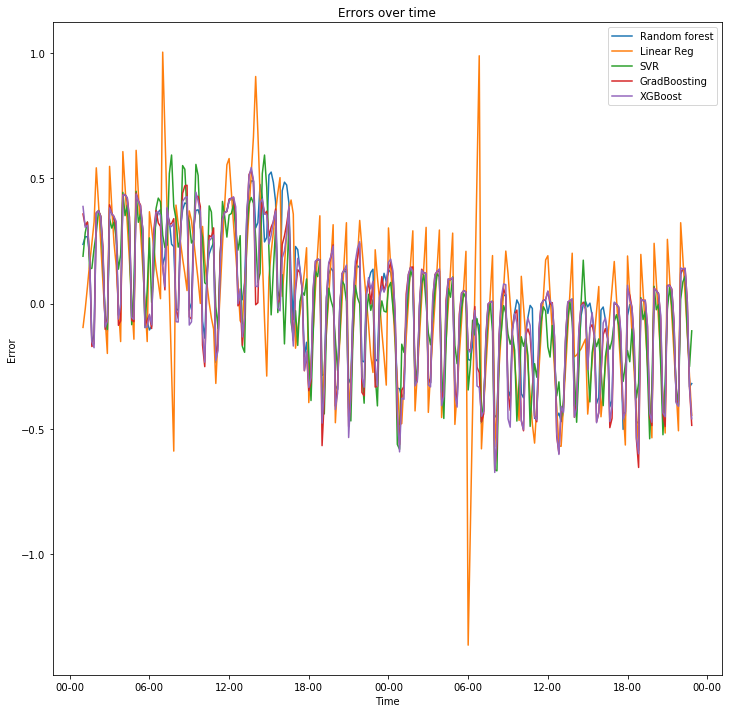

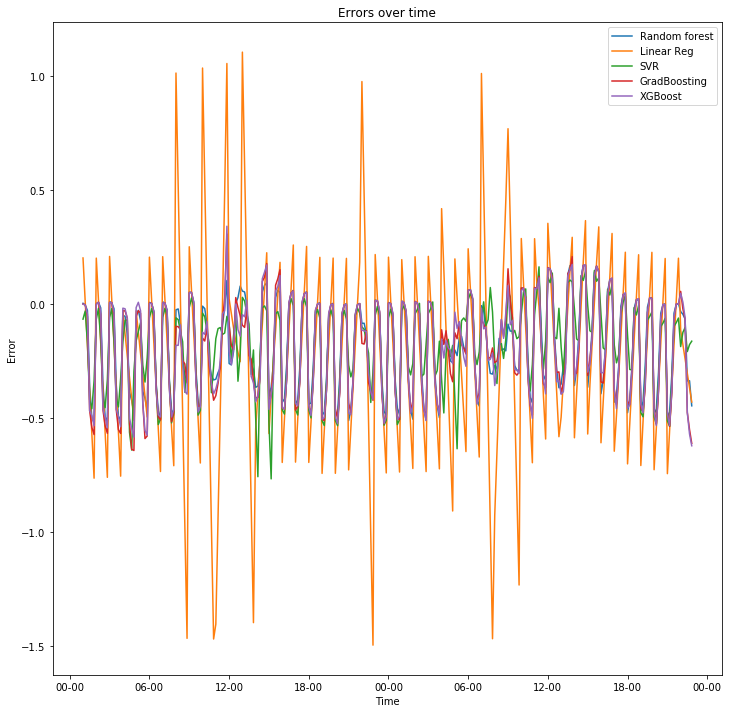

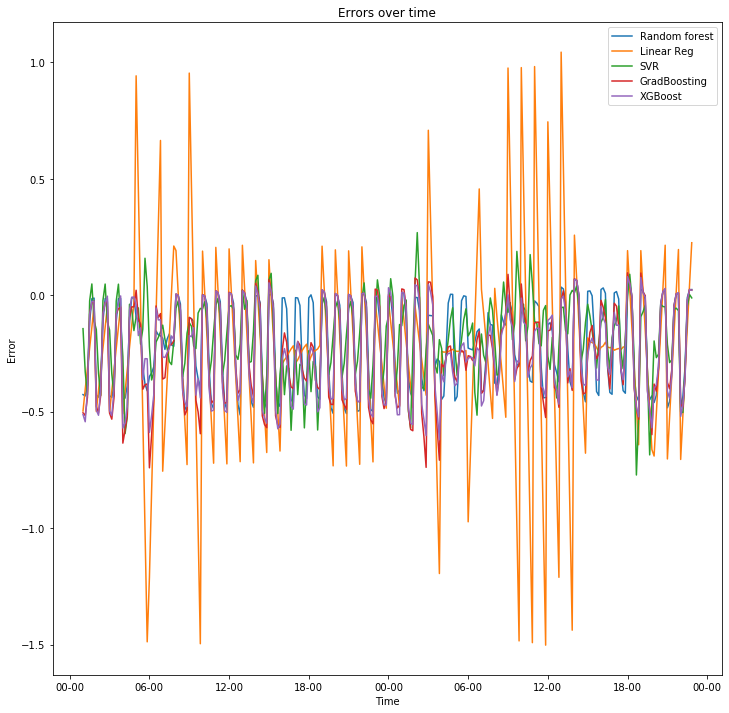

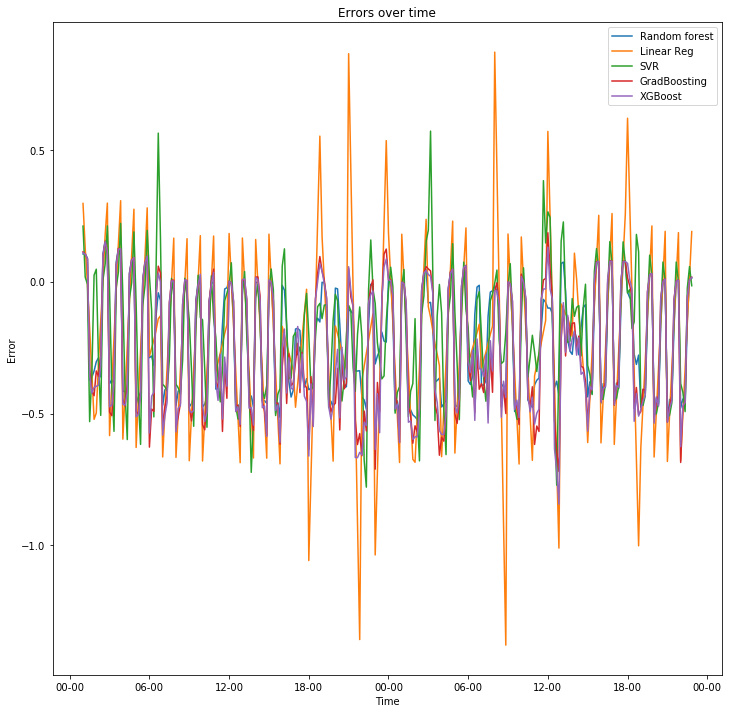

In [80]:
# Results for preprocessed data
for f in range(len(timeframes)):
    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
    for k in range(len(regressor_str)):
        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
    plot_errors(globals()["df_errors"+str(f)])

In [81]:
# Results for preprocessed data
for f in range(len(timeframes)):
    print(timeframes[f])
    for k in range(len(regressor_str)):
        print(regressor_str[k])
        for i in range(1,3):
            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
            print('The {} is: {}'.format(lists[i],res))

2019-01-11 00:00
RandomForest
The Mean squared value is: 0.05241881185592328
The Root mean squared value is: 0.22379616320528833
LinReg
The Mean squared value is: 0.10103651622022136
The Root mean squared value is: 0.2887595059237863
SVR
The Mean squared value is: 0.03224102684711501
The Root mean squared value is: 0.16692211353245082
GradientBoosting
The Mean squared value is: 0.051638540677923124
The Root mean squared value is: 0.22278005881188498
XGBReg
The Mean squared value is: 0.05099799332881385
The Root mean squared value is: 0.22108300793006477
2019-02-11 00:00
RandomForest
The Mean squared value is: 0.06667466662330455
The Root mean squared value is: 0.25176465156568545
LinReg
The Mean squared value is: 0.10214812026793109
The Root mean squared value is: 0.30011081506310533
SVR
The Mean squared value is: 0.0669306585209835
The Root mean squared value is: 0.24695777924612483
GradientBoosting
The Mean squared value is: 0.07654669663231772
The Root mean squared value is: 0.27214

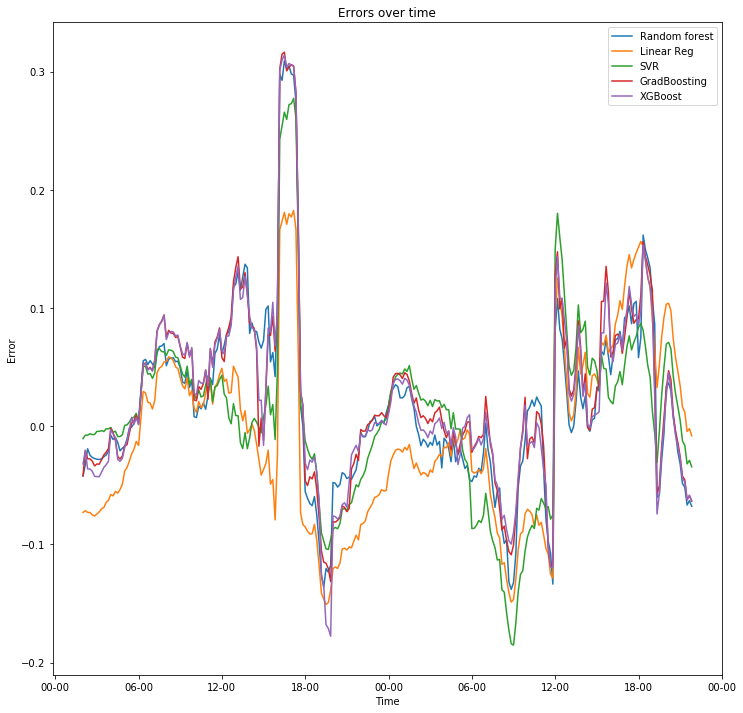

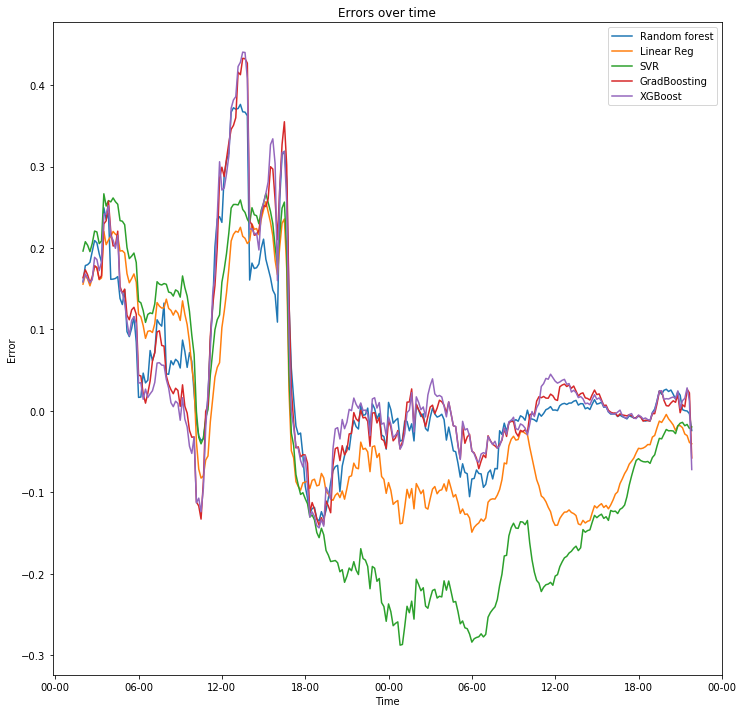

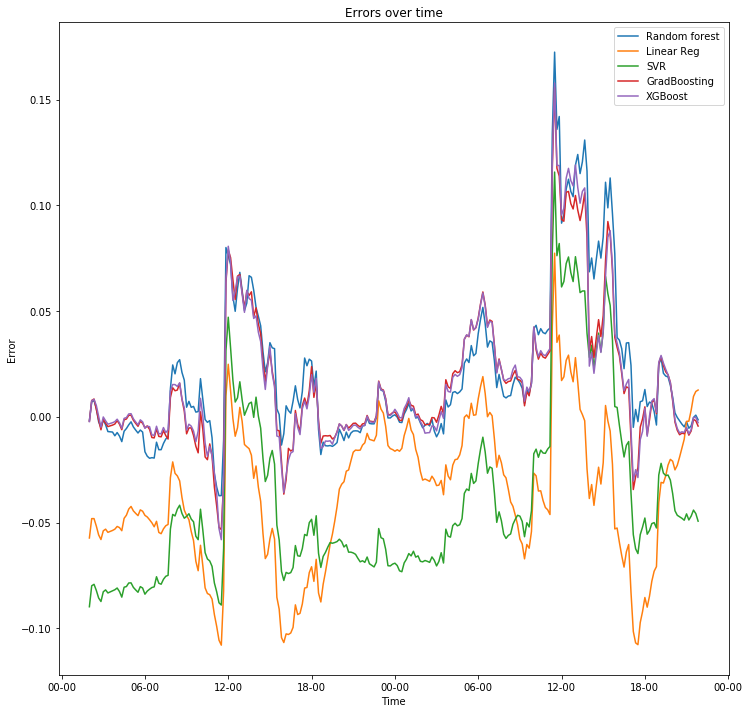

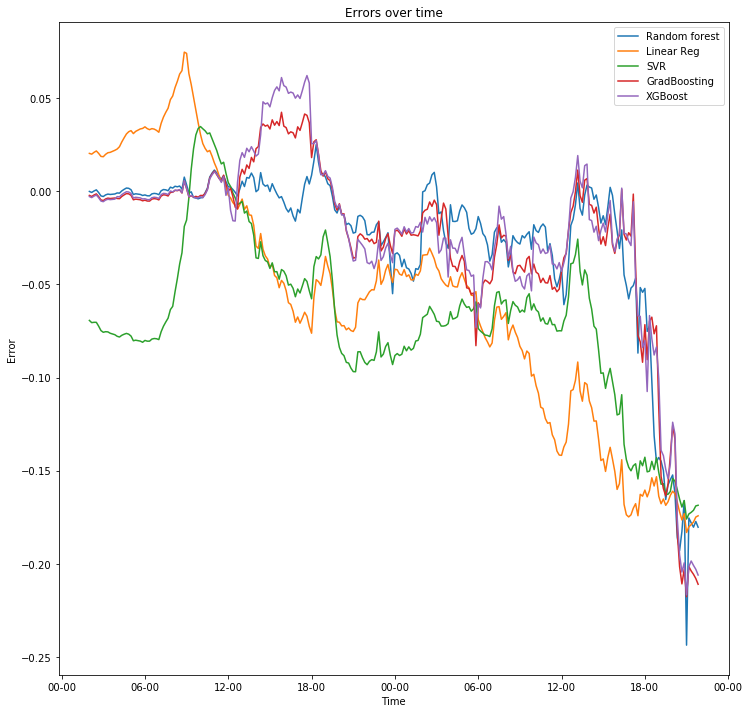

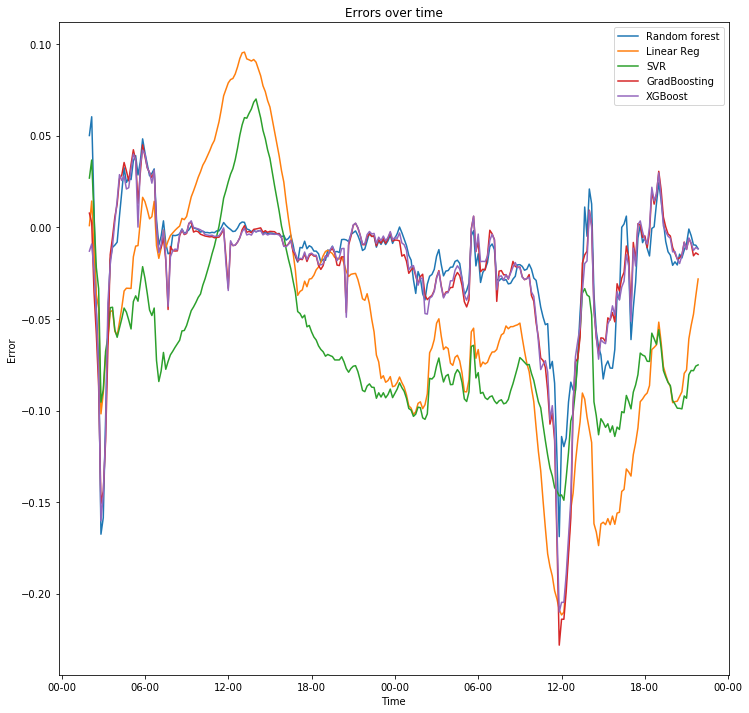

In [36]:
# combining error lists for each date - lag of 2 hours
for f in range(len(timeframes)):
    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
    for k in range(len(regressor_str)):
        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
    plot_errors(globals()["df_errors"+str(f)])

In [37]:
# results predicting different timeslots with different regressors - lag of 2 hours
for f in range(len(timeframes)):
    print(timeframes[f])
    for k in range(len(regressor_str)):
        print(regressor_str[k])
        for i in range(1,3):
            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
            print('The {} is: {}'.format(lists[i],res))

2019-01-11 00:00
RandomForest
The Mean squared value is: 0.00629315564039564
The Root mean squared value is: 0.06157682907553212
LinReg
The Mean squared value is: 0.005889041057597688
The Root mean squared value is: 0.0672719980734457
SVR
The Mean squared value is: 0.005758886543278679
The Root mean squared value is: 0.058003203217150356
GradientBoosting
The Mean squared value is: 0.006705962374556243
The Root mean squared value is: 0.0643904602138587
XGBReg
The Mean squared value is: 0.00667178147842518
The Root mean squared value is: 0.06380299247954384
2019-02-11 00:00
RandomForest
The Mean squared value is: 0.013391143818701821
The Root mean squared value is: 0.07930879098402456
LinReg
The Mean squared value is: 0.015074102294837617
The Root mean squared value is: 0.111755727839454
SVR
The Mean squared value is: 0.034436708187451565
The Root mean squared value is: 0.17335192914099942
GradientBoosting
The Mean squared value is: 0.01577503954677355
The Root mean squared value is: 0.0

## Time Series Models

### Plots for time series

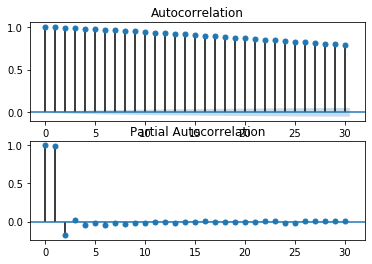

In [40]:
# ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(Y3, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(Y3, ax=plt.gca(), lags = 30)
plt.show()

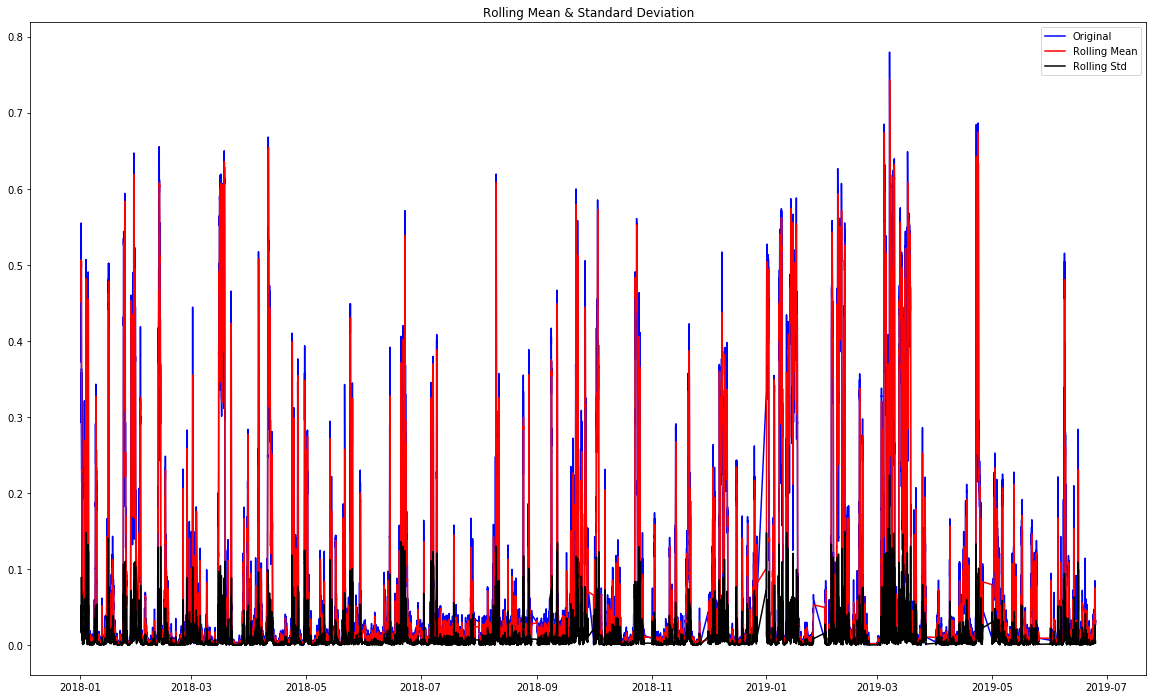

Results of Dickey-Fuller Test:
Test Statistic                -1.398105e+01
p-value                        4.176917e-26
#Lags Used                     6.100000e+01
Number of Observations Used    7.061200e+04
Critical Value (1%)           -3.430443e+00
Critical Value (5%)           -2.861581e+00
Critical Value (10%)          -2.566792e+00
dtype: float64


In [41]:
from statsmodels.tsa.stattools import adfuller

#Determing rolling statistics
rolmean = pd.Series(Y3).rolling(window=12).mean()
rolstd = pd.Series(Y3).rolling(window=12).std()

#Plot rolling statistics:
fig, ax = plt.subplots(figsize=(20,12))
orig = plt.plot(Y3, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
    
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(Y3, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

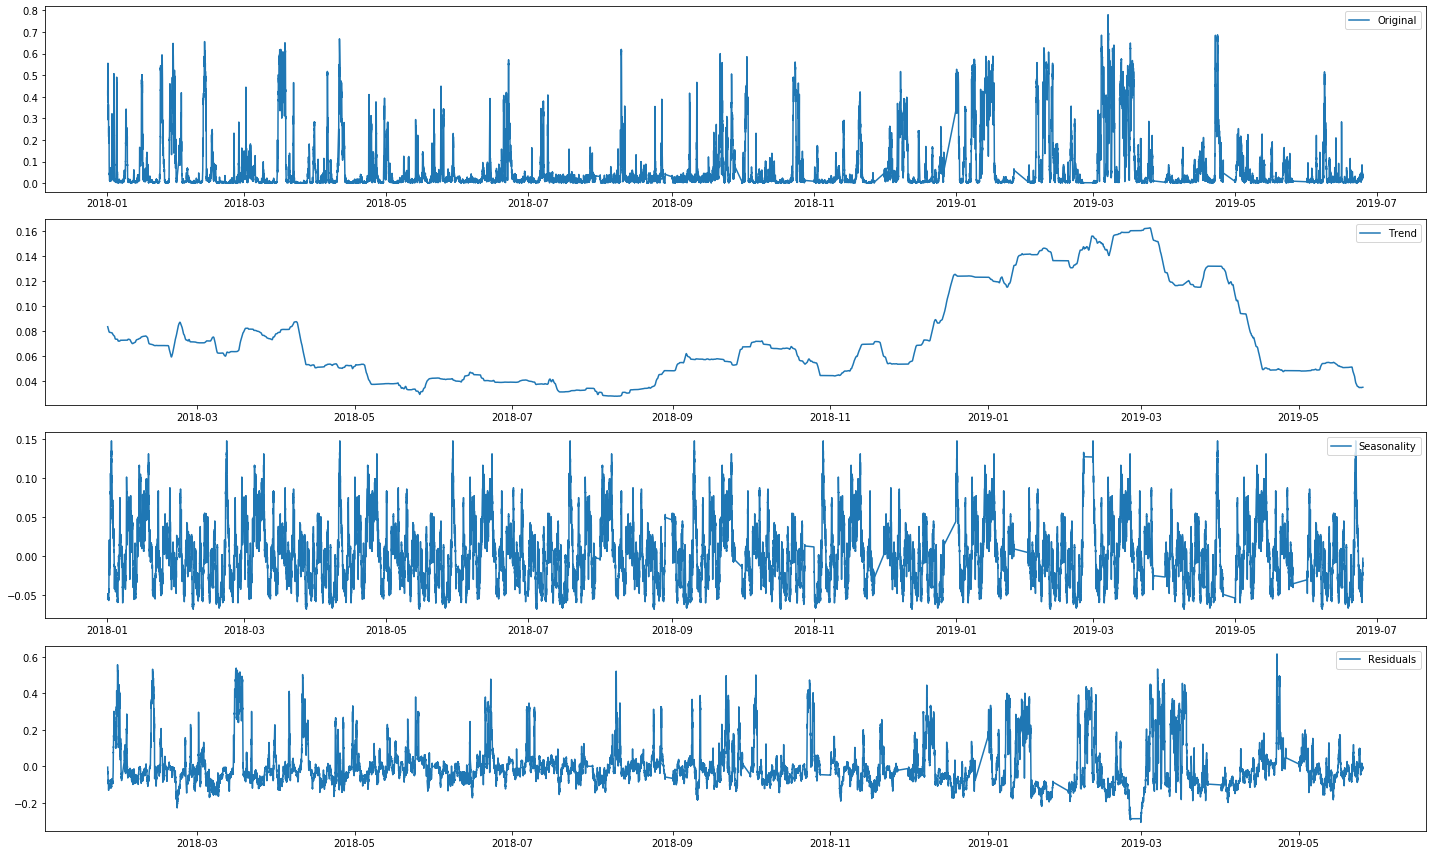

In [42]:
# Seasonal trends
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Y3,period=7000)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig,ax = plt.subplots(figsize=(20,12))
plt.subplot(411)
plt.plot(Y3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [43]:
from statsmodels.tsa.ar_model import AR
from random import random

In [44]:
ts_log = np.log(Y3)
ts_log_diff = ts_log- ts_log.shift(4)
#ts_y3_diff = Y3-Y3.shift(6)
ts_log_diff.dropna(inplace=True)
model = AR(ts_log_diff)
model_fit = model.fit()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



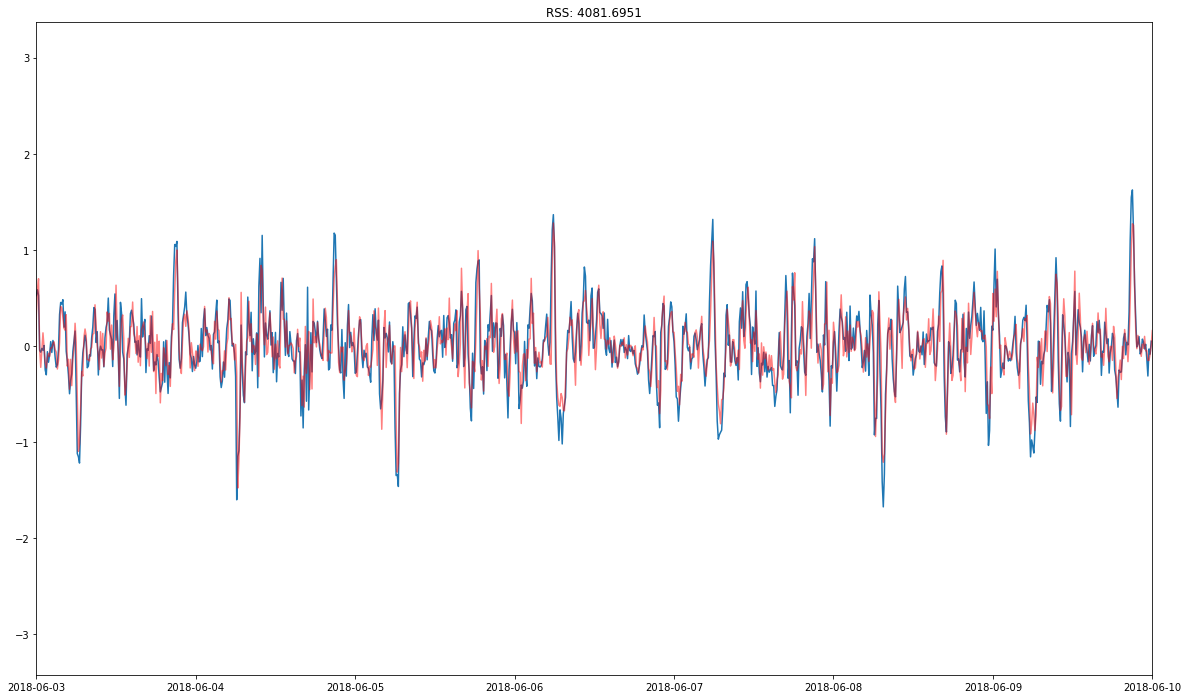

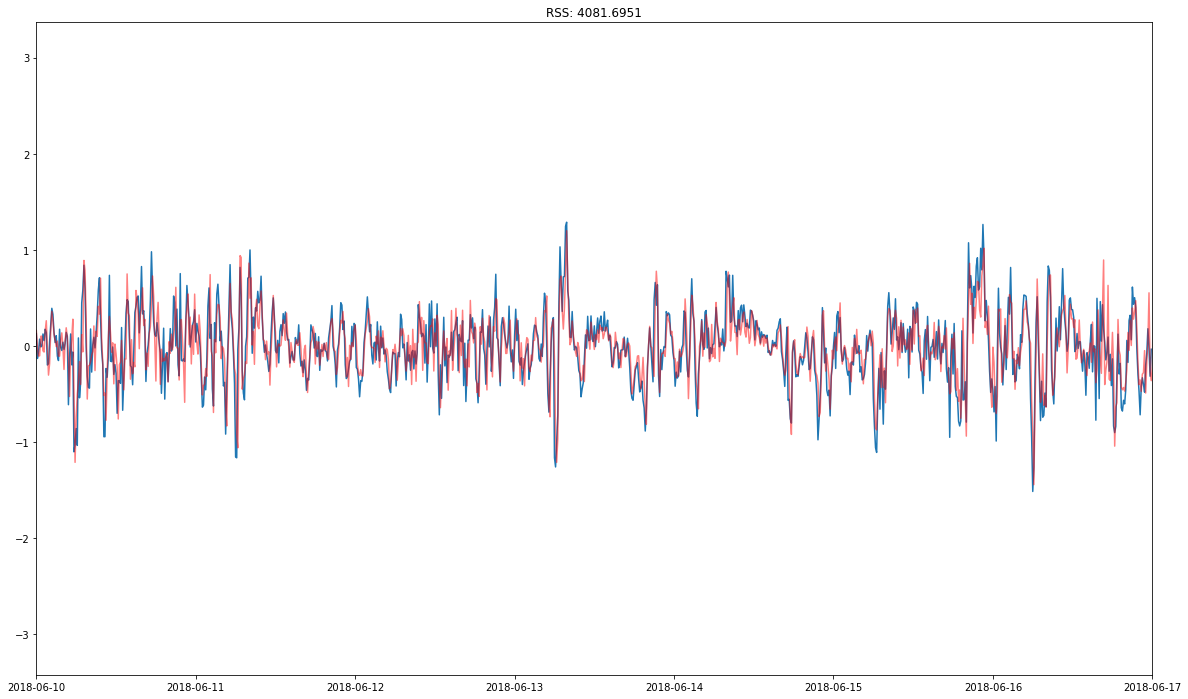

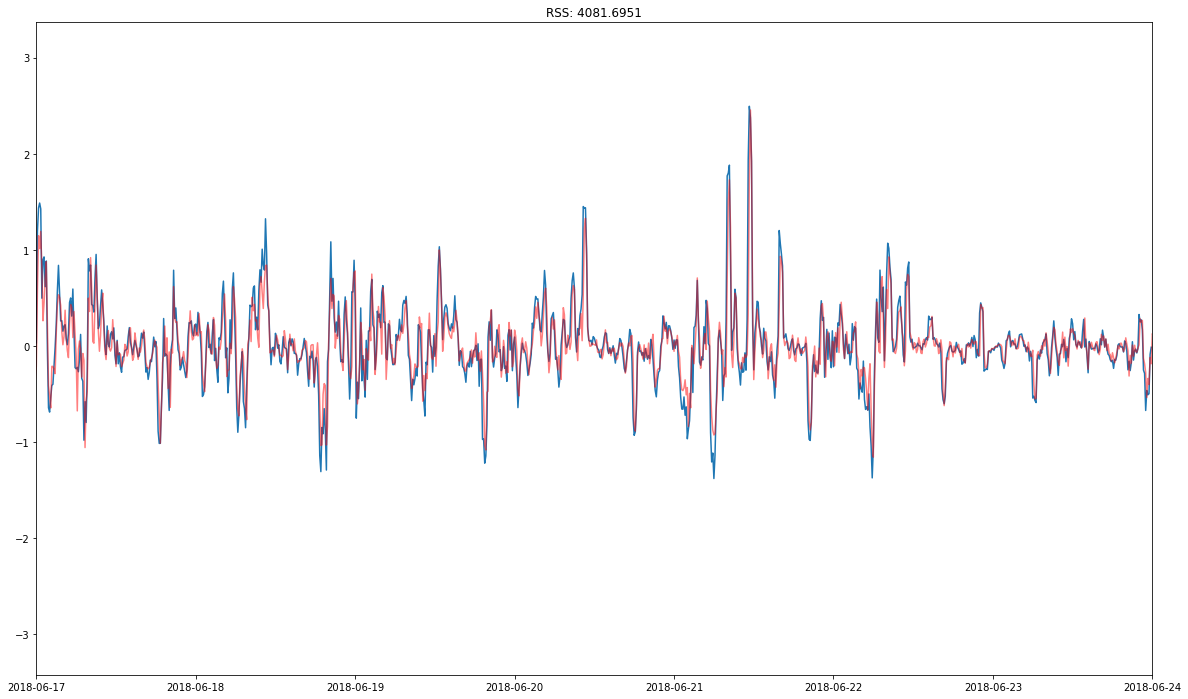

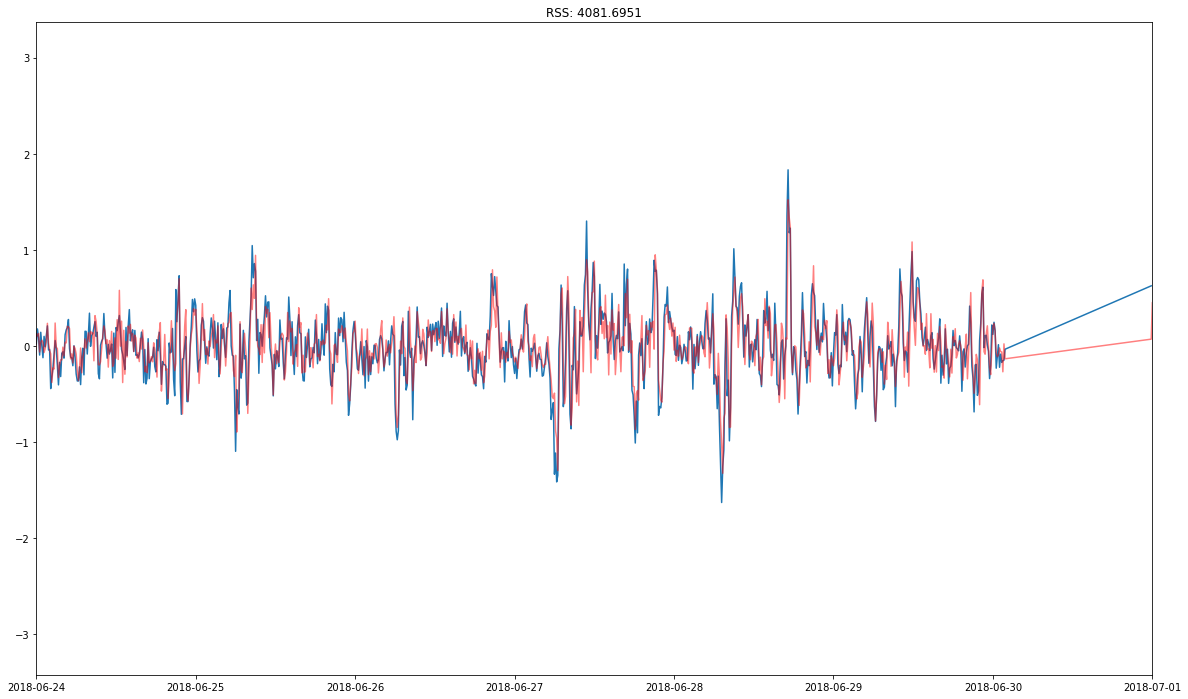

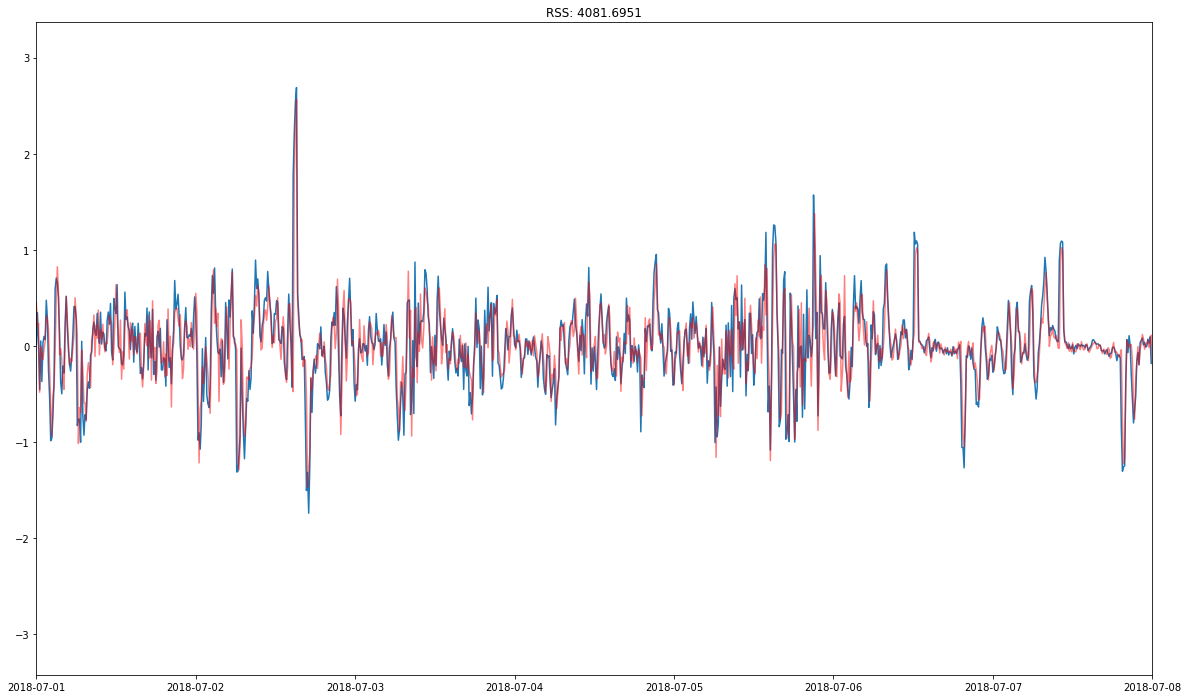

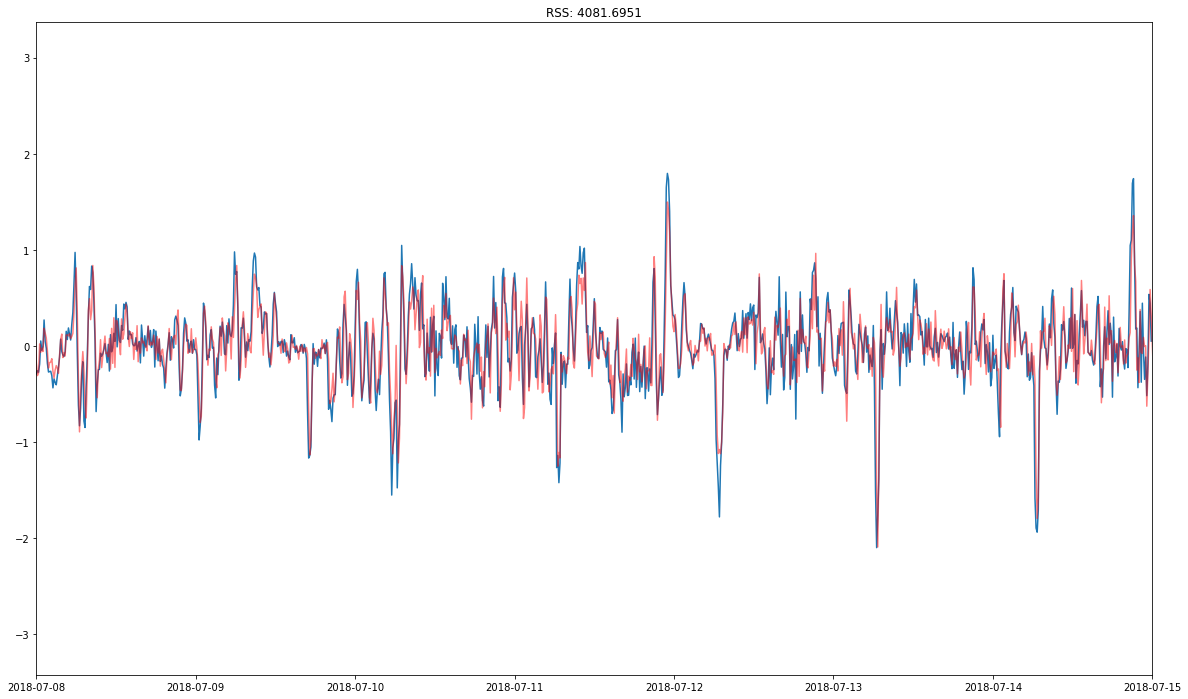

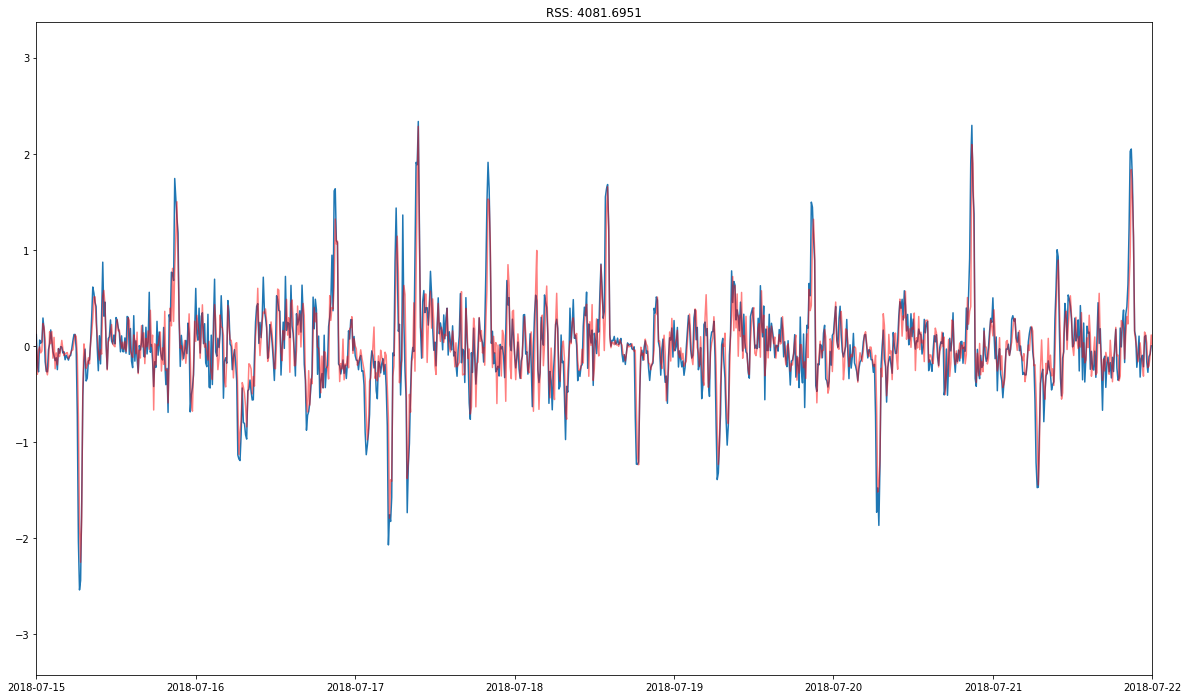

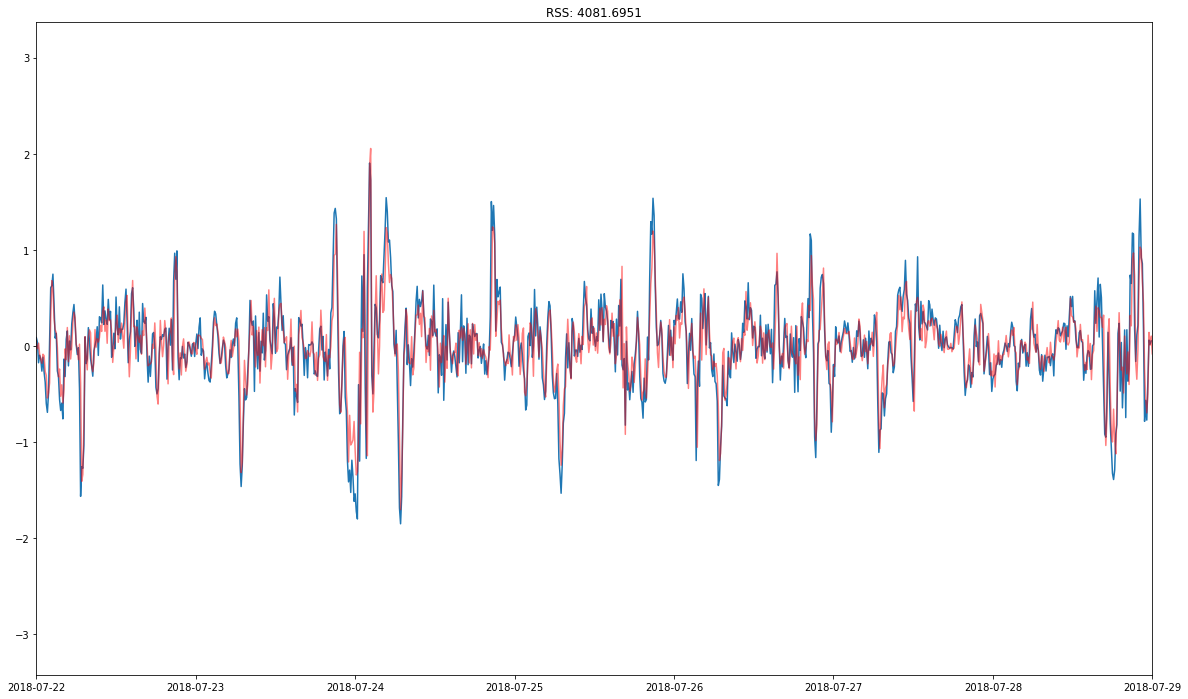

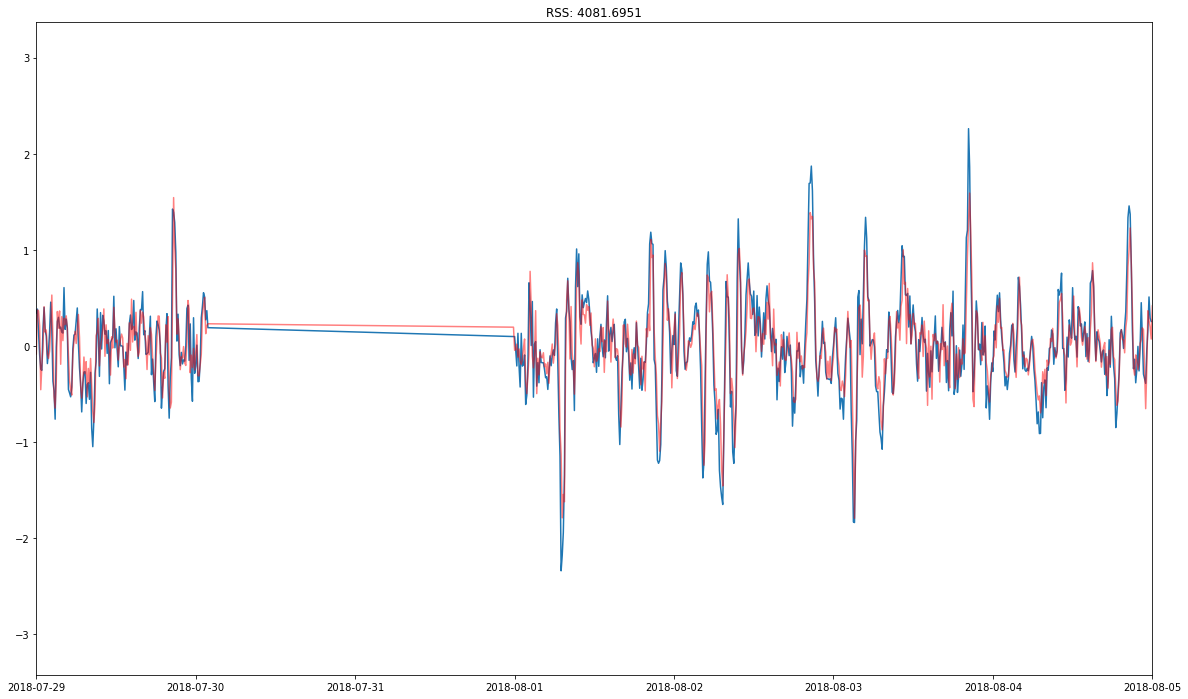

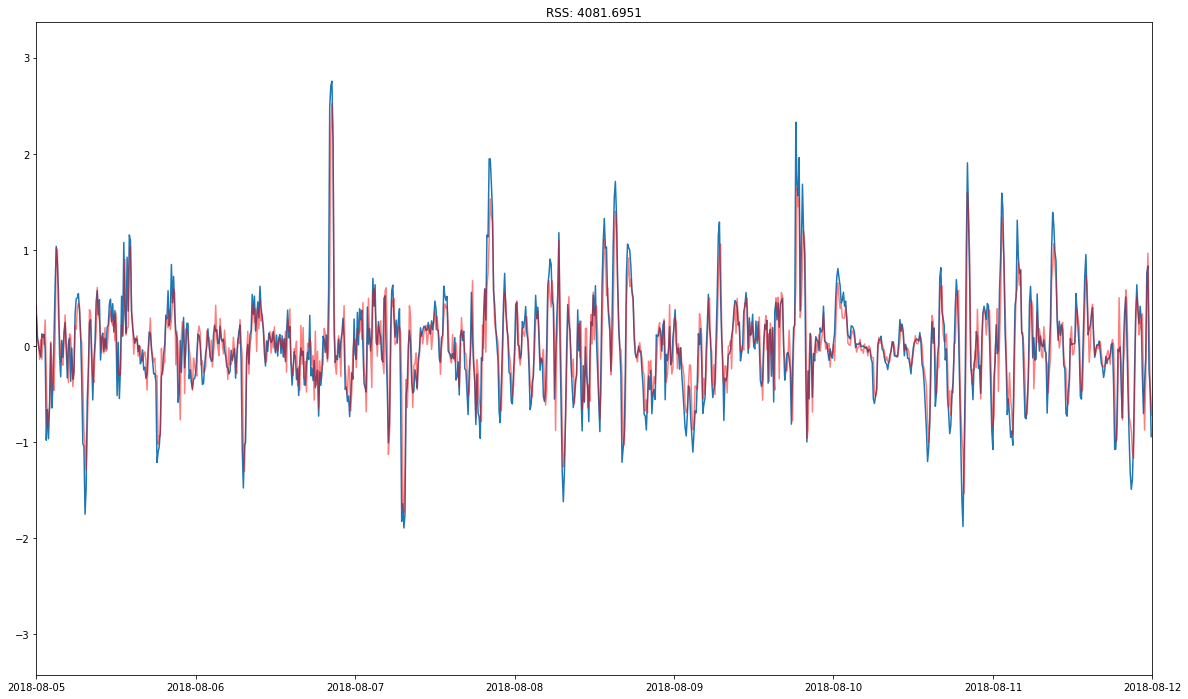

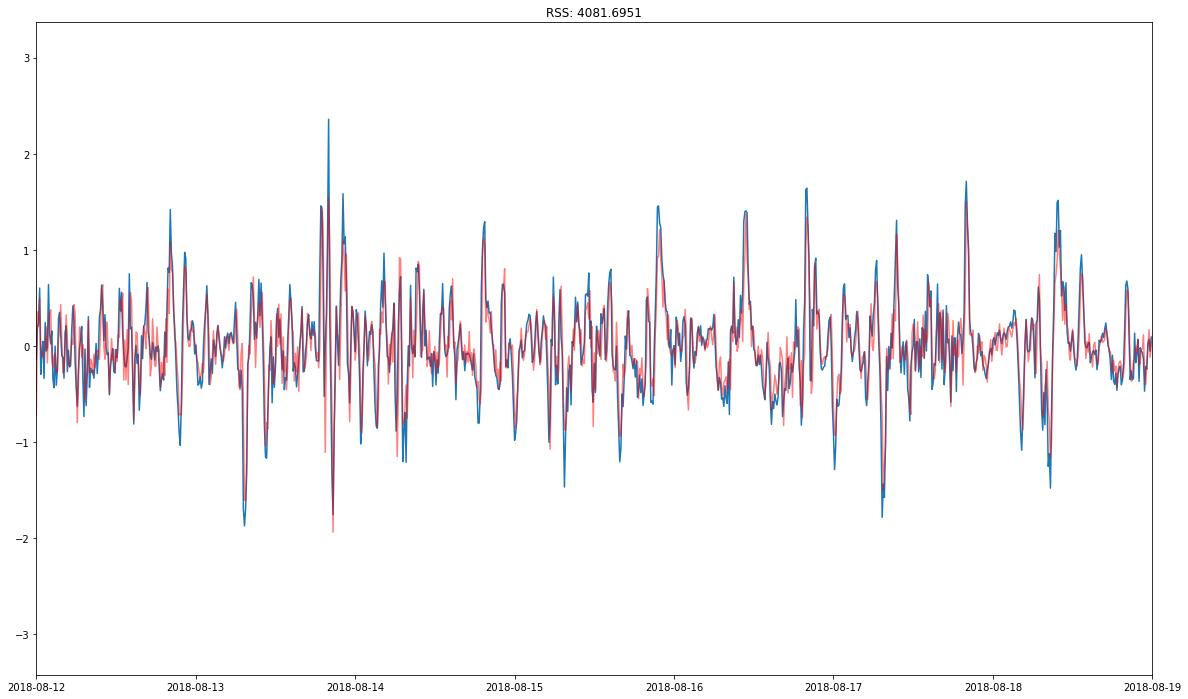

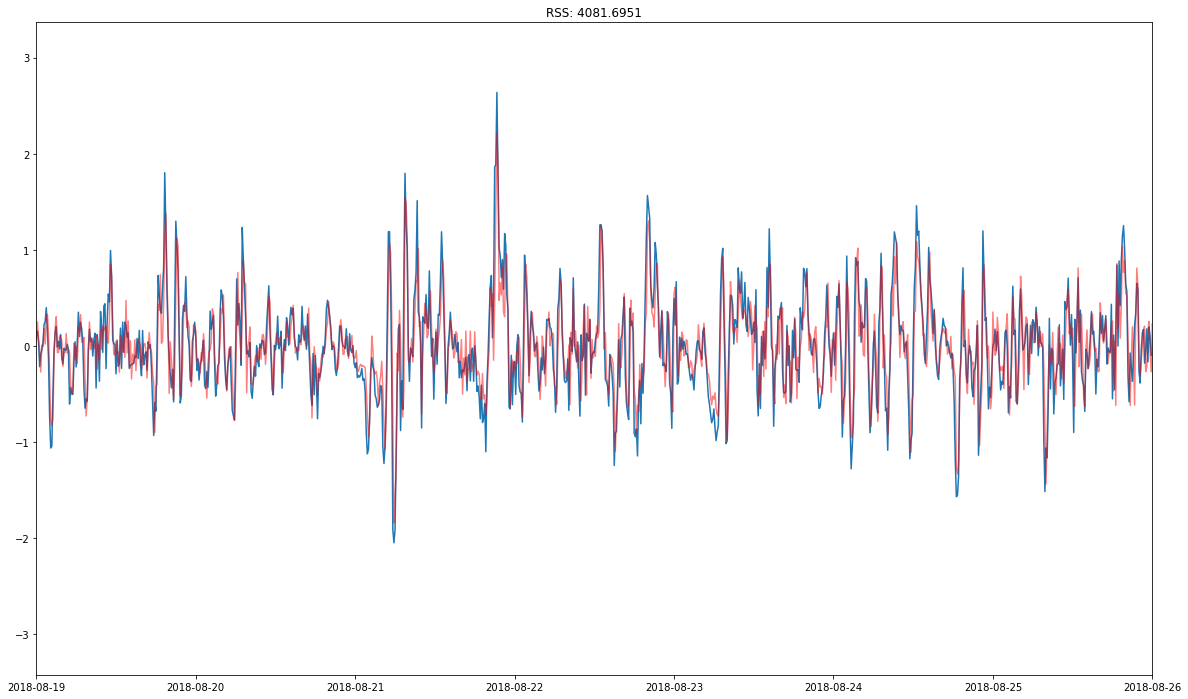

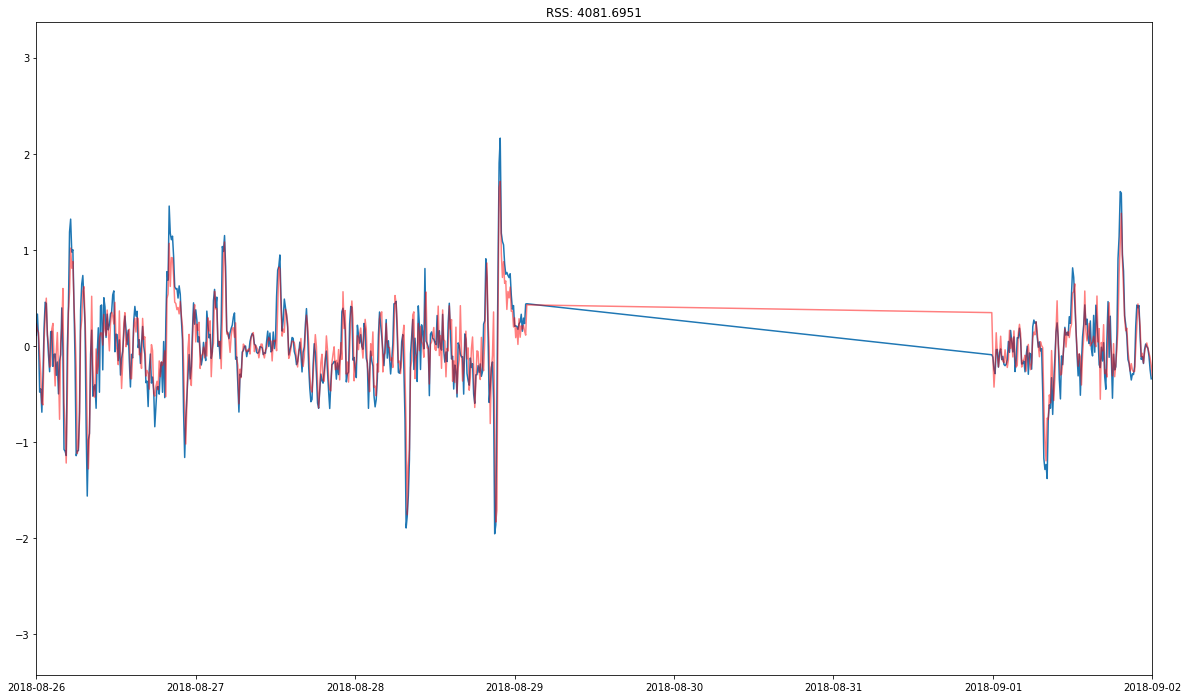

In [45]:
date_list = pd.date_range('2018-06-01 00:00', periods=14, freq='W')
for i in range(len(date_list)-1):
    timeframe = (ts_log_diff.index >= date_list[i]) & (ts_log_diff.index < date_list[i+1])
    fig,ax = plt.subplots(figsize=(20,12))
    plt.plot(ts_log_diff[timeframe])
    plt.xlim(left=date_list[i],right=date_list[i+1])
    plt.plot(model_fit.fittedvalues, color='red',alpha=0.5)
    plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
    plt.show()

2018-01-01 17:00:00    0.018133
2018-01-01 17:10:00   -0.017382
2018-01-01 17:20:00   -0.281760
2018-01-01 17:30:00   -0.338863
2018-01-01 17:40:00   -0.043649
dtype: float64
2018-01-01 17:00:00    0.018133
2018-01-01 17:10:00    0.000750
2018-01-01 17:20:00   -0.281010
2018-01-01 17:30:00   -0.619873
2018-01-01 17:40:00   -0.663521
dtype: float64


Text(0.5, 1.0, 'RMSE: 0.3001')

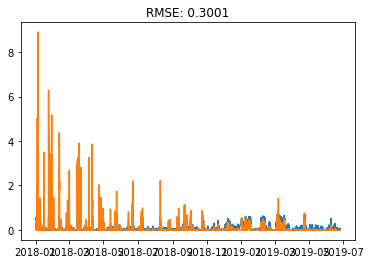

In [46]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Y3)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-Y3)**2)/len(Y3)))

In [47]:
evaluate_forecast(Y3, predictions_ARIMA)

r2_score  mean_absolute_error       mse      rmse
0 -4.469602             0.076198  0.090062  0.300103

In [49]:
from statsmodels.tsa.arima_model import ARIMA

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARIMA Model Results                               
Dep. Variable:     D.target_losses_norm   No. Observations:                70673
Model:                   ARIMA(5, 1, 0)   Log Likelihood              218714.563
Method:                         css-mle   S.D. of innovations              0.011
Date:                  Fri, 07 Aug 2020   AIC                        -437415.126
Time:                          09:29:26   BIC                        -437350.965
Sample:                               1   HQIC                       -437395.346
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                      -5.558e-06   5.47e-05     -0.102      0.919      -0.000       0.000
ar.L1.D.target_losses_norm     0.1839      0.004     48.924      0.

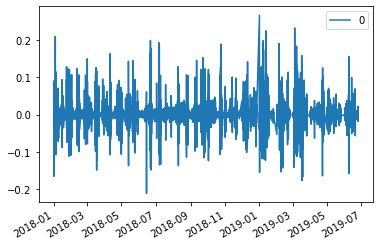

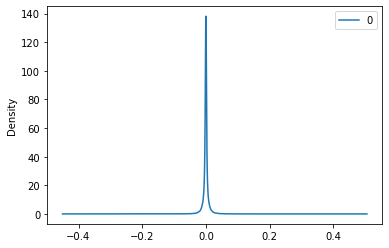

                  0
count  7.067300e+04
mean  -1.836418e-08
std    1.095817e-02
min   -2.112067e-01
25%   -1.842698e-03
50%    1.472078e-05
75%    1.742834e-03
max    2.666974e-01


In [52]:
series = pd.Series(Y3)
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
X = series.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## ARIMA

In [46]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
train = Y3[:int(0.75*(len(Y3)))]
valid = Y3[int(0.75*(len(Y3))):]
# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [47]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     target_losses_norm   No. Observations:                53005
Model:                 ARIMA(1, 1, 1)   Log Likelihood              165657.091
Date:                Thu, 06 Aug 2020   AIC                        -331308.183
Time:                        16:44:03   BIC                        -331281.549
Sample:                             0   HQIC                       -331299.862
                              - 53005                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0153      0.011     -1.343      0.179      -0.038       0.007
ma.L1          0.1915      0.011     16.711      0.000       0.169       0.214
sigma2         0.0001   1.16e-07    973.732      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      423.34   Jarque-Bera (JB):          11400949.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        74.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=1, end=17669)

In [49]:
evaluate_forecast(Y3[start_index:end_index], predictions)


r2_score  mean_absolute_error       mse      rmse
0 -0.844489             0.122937  0.041807  0.204467

## Auto ARIMA

In [53]:
from pmdarima.utils import acf

ImportError: cannot import name 'six'

In [54]:
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

ModuleNotFoundError: No module named 'pyramid.arima'

In [ ]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

# Openweather API

In [38]:
openweather_api_key ='f1afaaf6a82c52ed15b283488ae2f377'
openweather_api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&units=metric&appid={your api key}'

urllib.request.urlopen(openweather_api_url).read() 
response = urllib.request.urlopen(openweather_api_url).read()
json_obj = str(response, 'utf-8')
forecast_load = json.loads(json_obj)

In [39]:
def forecast(lat,long):
    url='https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&exclude=current,minutely,daily&units=metric&appid=f1afaaf6a82c52ed15b283488ae2f377'.format(lat,long)
    urllib.request.urlopen(url).read() 
    response = urllib.request.urlopen(url).read()
    json_obj = str(response, 'utf-8')
    forecast_load = json.loads(json_obj)
    df_forecast = pd.DataFrame(forecast_load['hourly']).copy()
    df_forecast['dt'] = df_forecast.dt.apply(lambda x : datetime.fromtimestamp(x))
    df_forecast = df_forecast.set_index('dt')
    forecast_cols = ['clouds', 'dew_point', 'feels_like', 'humidity', 'pop','visibility', 'weather']
    dict_forec = {'wind_speed':'wsp_10m_ms','temp':'t_2m_k','wind_deg':'wdir_10m_dn','pressure':'msl_ms_pa'}

    if len(df_forecast.columns)>4:
        for i in forecast_cols:
            df_forecast.pop(i)
    df_forecast = df_forecast.rename(columns=dict_forec)
    df_forecast['msl_ms_pa'] = df_forecast['msl_ms_pa'].apply(lambda x : x*100)
    df_forecast['t_2m_k'] = df_forecast['t_2m_k'].apply(lambda x : x+273,15)

    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_forecast[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms']].copy()
    x_test_forecast['wsp_100m_ms'] = x_test_forecast['wsp_10m_ms'].apply(lambda x: x/0.64)

    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

Mean squared error: 0.003969
Root mean squared error: 0.062997
Explained variance score: 0.758992
R-squared score: 0.758981


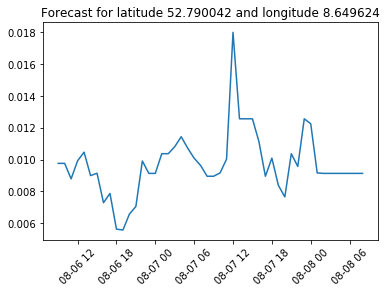

target_losses_norm
dt                                     
2020-08-06 09:00:00            0.009762
2020-08-06 10:00:00            0.009762
2020-08-06 11:00:00            0.008791
2020-08-06 12:00:00            0.009925
2020-08-06 13:00:00            0.010463
2020-08-06 14:00:00            0.008994
2020-08-06 15:00:00            0.009142
2020-08-06 16:00:00            0.007295
2020-08-06 17:00:00            0.007876
2020-08-06 18:00:00            0.005639
2020-08-06 19:00:00            0.005582
2020-08-06 20:00:00            0.006580
2020-08-06 21:00:00            0.007059
2020-08-06 22:00:00            0.009913
2020-08-06 23:00:00            0.009133
2020-08-07 00:00:00            0.009133
2020-08-07 01:00:00            0.010369
2020-08-07 02:00:00            0.010369
2020-08-07 03:00:00            0.010807
2020-08-07 04:00:00            0.011434
2020-08-07 05:00:00            0.010715
2020-08-07 06:00:00            0.010085
2020-08-07 07:00:00            0.009626
2020-08-07 08:00:00            0.008955
2020-08-07 09:00:00            0.008955
2020-08-07 10:00:00            0.009163
2020-08-07 11:00:00            0.010026
2020-08-07 12:00:00            0.017978
2020-08-07 13:00:00            0.012556
2020-08-07 14:00:00            0.012556
2020-08-07 15:00:00            0.012556
2020-08-07 16:00:00            0.011128
2020-08-07 17:00:00            0.008955
2020-08-07 18:00:00            0.010089
2020-08-07 19:00:00            0.008388
2020-08-07 20:00:00            0.007657
2020-08-07 21:00:00            0.010369
2020-08-07 22:00:00            0.009567
2020-08-07 23:00:00            0.012556
2020-08-08 00:00:00            0.012246
2020-08-08 01:00:00            0.009163
2020-08-08 02:00:00            0.009133
2020-08-08 03:00:00            0.009133
2020-08-08 04:00:00            0.009133
2020-08-08 05:00:00            0.009133
2020-08-08 06:00:00            0.009133
2020-08-08 07:00:00            0.009133
2020-08-08 08:00:00            0.009133

In [40]:
forecast(52.790042, 8.649624)

- dict with location and coordinates as a tuple

- 6 lat and long coordinates with historical Data to teach the model (calculate wsp100m with ratio of last year)

- getting the current weather forecast via api

- predict einsman actions over the next 48 hours with forecast

- visualize einsman actions in a dashboard with a map(slider for 48 hours), raw data

- hourly and monthly average of ratio between wsp 10 and wsp100


# Climacell API (short term 6hrs)

In [41]:
climacell_api_key = 'QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'
climacell_api_url = 'https://api.climacell.co/v3/locations?apikey=QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'

In [42]:
url = "https://api.climacell.co/v3/weather/nowcast"
querystring = {"lat":"52.790042","lon":"8.649624","unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
response = requests.request("GET", url, params=querystring)

In [43]:
tex = pd.read_json(response.text)

In [44]:
tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)

In [45]:
df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]

In [46]:
def climacell_pred(lat,long):    
    
    url = "https://api.climacell.co/v3/weather/nowcast"
    querystring = {"lat":"{}".format(lat),"lon":"{}".format(long),"unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
    response = requests.request("GET", url, params=querystring)
    tex = pd.read_json(response.text)
    
    tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
    tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
    tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
    tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
    tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)
    df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]
    
    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_climacell[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    
    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

Mean squared error: 0.004153
Root mean squared error: 0.064443
Explained variance score: 0.74788
R-squared score: 0.74779


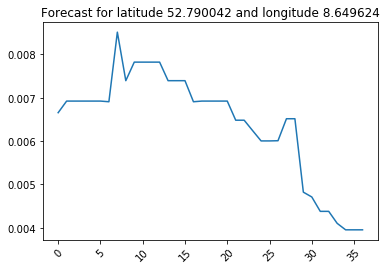

target_losses_norm
0             0.006652
1             0.006920
2             0.006920
3             0.006920
4             0.006920
5             0.006920
6             0.006905
7             0.008507
8             0.007390
9             0.007817
10            0.007817
11            0.007817
12            0.007817
13            0.007390
14            0.007390
15            0.007390
16            0.006905
17            0.006920
18            0.006920
19            0.006920
20            0.006920
21            0.006479
22            0.006479
23            0.006239
24            0.006002
25            0.006002
26            0.006007
27            0.006513
28            0.006513
29            0.004822
30            0.004711
31            0.004380
32            0.004380
33            0.004103
34            0.003954
35            0.003954
36            0.003954

In [47]:
climacell_pred(52.790042, 8.649624)

# First tries in modelling without considering time series 

In [48]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression(normalize=True)
y_train1_pred_lin = cross_val_predict(model, preproc(x_train1), y_train1, cv=5)
# model = model.fit(x_train1, y_train1)
# y_test1_pred_lin = model.pred_linict(x_test1)
regr_eval(y_train1, y_train1_pred_lin, return_scores=False)

Mean squared error: 0.005814
Root mean squared error: 0.076248
Explained variance score: 0.779299
R-squared score: 0.779299


In [49]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression()
y_train2_pred_lin = cross_val_predict(model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_lin, return_scores=False)

Mean squared error: 0.010843
Root mean squared error: 0.104129
Explained variance score: 0.844074
R-squared score: 0.844074


In [50]:
# pred_liniction for power_available_mw_obsnorm
model = LinearRegression()
y_train3_pred_lin = cross_val_predict(model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_lin, return_scores=False)

Mean squared error: 0.006015
Root mean squared error: 0.077558
Explained variance score: 0.632521
R-squared score: 0.632521


In [51]:
# plot_resid_hist(y_train3, y_train3_pred_lin)
# plot_resid_boxp(y_train3, y_train3_pred_lin)

## Polynominal Linear Regression

In [52]:
x_train1_poly = PolynomialFeatures(degree=2).fit_transform(x_train1)
model = LinearRegression()
y_train1_pred_poly = cross_val_predict(model, x_train1_poly, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_poly, return_scores=False)

Mean squared error: 0.00545
Root mean squared error: 0.073824
Explained variance score: 0.793107
R-squared score: 0.793107


In [53]:
x_train2_poly = PolynomialFeatures(degree=2).fit_transform(x_train2)
model = LinearRegression()
y_train2_pred_poly = cross_val_predict(model, x_train2_poly, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_poly, return_scores=False)

Mean squared error: 0.009325
Root mean squared error: 0.096568
Explained variance score: 0.865895
R-squared score: 0.865895


In [54]:
x_train3_poly = PolynomialFeatures(degree=2).fit_transform(x_train3)
model = LinearRegression()
y_train3_pred_poly = cross_val_predict(model, x_train3_poly, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_poly, return_scores=False)

Mean squared error: 0.004195
Root mean squared error: 0.064769
Explained variance score: 0.743724
R-squared score: 0.743724


In [55]:
x_train_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_train_tf)
x_test_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_test_tf)
model = LinearRegression()
model = model.fit(x_train_tf_poly, y_train_tf)
y_test_tf_pred = model.predict(x_test_tf_poly)
regr_eval(y_test_tf, y_test_tf_pred, return_scores=False)

Mean squared error: 0.007121
Root mean squared error: 0.084384
Explained variance score: 0.7378
R-squared score: 0.727348


In [56]:
#plot_resid_hist(y_train3, y_train3_pred_poly)
#plot_resid_boxp(y_train3, y_train3_pred_poly)

## Support Vector Regressor

Best results and fastest calculating with only wind features

In [57]:
svr_model = SVR(kernel='rbf')
y_train1_pred_svr = cross_val_predict(svr_model, preproc(x_train1), y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_svr, return_scores=False)

Mean squared error: 0.005103
Root mean squared error: 0.071433
Explained variance score: 0.813324
R-squared score: 0.806292


In [ ]:
svr_model = SVR(kernel='rbf')
y_train2_pred_svr = cross_val_predict(svr_model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_svr, return_scores=False)

In [ ]:
# predicting losses with support vectore regression
svr_model = SVR(kernel='rbf')
y_train3_pred_svr = cross_val_predict(svr_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_svr, return_scores=False)

In [ ]:
# predicting losses for a whole timeframe
svr_model = SVR(kernel='poly')
svr_model = svr_model.fit(preproc(x_train_tf), y_train_tf)
y_test_tf_pred_svr = svr_model.predict(preproc(x_test_tf))
regr_eval(y_test_tf, y_test_tf_pred_svr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_svr)

In [ ]:
# calculating the losses
#regr_eval(y_train3, (y_train2_pred_svr-y_train1_pred_svr), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_svr-y_train1_pred_svr))
#plot_resid_boxp(y_train3, (y_train2_pred_svr-y_train1_pred_svr))

## KNN

In [ ]:
knn_model = KNeighborsRegressor(6)
y_train1_pred_knn = cross_val_predict(knn_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_knn, return_scores=False)

In [ ]:
knn_model = KNeighborsRegressor(6)
y_train2_pred_knn = cross_val_predict(knn_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_knn, return_scores=False)

In [ ]:
knn_model = KNeighborsRegressor(20)
y_train3_pred_knn = cross_val_predict(knn_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_knn, return_scores=False)
#plot_resid_hist(y_train3, y_train3_pred_knn)
#plot_resid_boxp(y_train3, y_train3_pred_knn)

In [ ]:
knn_model = KNeighborsRegressor(20)
knn_model = knn_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_knn = knn_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_knn, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_knn)

In [ ]:
regr_eval(y_train3, (y_train2_pred_knn-y_train1_pred_knn), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_knn-y_train1_pred_knn))
#plot_resid_boxp(y_train3, (y_train2_pred_knn-y_train1_pred_knn))

## Random Forrest Regressor

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train1_pred_rfr = cross_val_predict(rfr_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train2_pred_rfr = cross_val_predict(rfr_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train3_pred_rfr = cross_val_predict(rfr_model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(#n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
)
rfr_model = rfr_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_rfr = rfr_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_rfr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_rfr)